#**Predicting the Prevalence of Obesity in U.S. Counties**

##Introduction

The objective of this analysis is to identify the most important characteristics for predicting the prevalence of obesity in U.S. counties.  For the study, demographic information such as income level and education will be assembled with data on obesity and the "Food Environment Atlas".
<br>
* The Food Environment Atlas, from the USDA, contains data on factors such as store/restaurant proximity, food prices, food and nutrition assistance programs, and community characteristics, which interact to influence food choices and diet quality.
<br>
* County-level data on educational attainment is also sourced from the USDA. 
<br>
* County-level measures of obesity prevalence are sourced from the Institute for Health Metrics and Evaluation (IHME).
<br>
* County-level data on poverty and income is sourced from the U.S. Census Bureau.

##Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import csv
import io
import itertools

from scipy import stats
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, mean_absolute_error 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn import ensemble
from sklearn.svm import SVR
from statsmodels.tools.eval_measures import mse, rmse
from collections import defaultdict

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

##Dictionaries

In [3]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
}

##Functions

In [4]:
# Create df of null_names, null_counts, null_proportion, and null_dtypes
def null_summary(df):
  var_null_list = df.columns[df.isna().any()]
  var_null_names = df[var_null_list].dtypes.index
  var_null_counts = df[var_null_list].isna().sum()
  var_null_proportion = df[var_null_list].isna().sum()/df[var_null_list].isna().count()
  var_null_dtypes = df[var_null_list].dtypes
  var_null_df = pd.DataFrame({'null_names' : var_null_names, 'null_counts' : var_null_counts, 'null_proportion' : var_null_proportion, 'null_dtypes' : var_null_dtypes})
  
  return var_null_df.reset_index(drop=True)

In [5]:
# Get Top Absolute Correlations
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr

In [6]:
def get_preds(method, method_title):

  y_preds_train = method.predict(X_train)
  y_preds_test = method.predict(X_test)

  preds_dict = {'Method' : method_title, 'train' : y_preds_train, 'test' : y_preds_test}

  return preds_dict

In [7]:
def get_metrics(method, method_title, preds_dict, comments):

  y_preds_train = preds_dict['train']
  y_preds_test = preds_dict['test']

  matches = ['GradientBoostingRegressor', 'RandomForestRegressor', 'SVR']
  if any(x in str(method) for x in matches):
    best_alpha = np.nan
  else:
    best_alpha = method.alpha_

  R_sq_train = method.score(X_train, y_train)
  R_sq_test = method.score(X_test, y_test)
  maerr = mean_absolute_error(y_test, y_preds_test)
  mserr = mse(y_test, y_preds_test)
  rmserr = rmse(y_test, y_preds_test)
  maperr = np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100

  metrics_dict = {'Method' : method_title, 'Best_alpha' : best_alpha, 'R_sq_train' : R_sq_train, 'R_sq_test' : R_sq_test,
                  'MAE': maerr, 'MSE' : mserr, 'RMSE' : rmserr, 'MAPE' : maperr, 'Comments' : comments}

  print("Best alpha value is: {}".format(best_alpha))
  print("R-squared of the model in training set is: {}".format(R_sq_train))
  print("-----Test set statistics-----")
  print("R-squared of the model in test set is: {}".format(R_sq_test))
  print("Mean absolute error of the prediction is: {}".format(maerr))
  print("Mean squared error of the prediction is: {}".format(mserr))
  print("Root mean squared error of the prediction is: {}".format(rmserr))
  print("Mean absolute percentage error of the prediction is: {}".format(maperr))
  
  return metrics_dict

In [8]:
def plot_feat_imp(method, method_title, top, X):
  
  matches = ['GradientBoostingRegressor', 'RandomForestRegressor']
  if any(x in str(method) for x in matches):
    feature_importance = method.feature_importances_
  else:
    feature_importance = np.abs(method.coef_)

  # Make importances relative to max importance.
  feature_importance = 100.0 * (feature_importance / feature_importance.max())
  sorted_idx = np.argsort(feature_importance)[-1*top:]
  pos = np.arange(sorted_idx.shape[0]) + .5
  plt.barh(pos, feature_importance[sorted_idx], align='center')
  plt.yticks(pos, X.columns[sorted_idx])
  plt.xlabel('Relative Importance')
  plt.title('Variable Importance ('+method_title+')')

In [9]:
def plot_coef(method, method_title, top, X):
  
  matches = ['GradientBoostingRegressor', 'RandomForestRegressor']
  if any(x in str(method) for x in matches):
    feature_importance = method.feature_importances_
    feature_importance_abs = method.feature_importances_
  else:
    feature_importance = method.coef_
    feature_importance_abs = np.abs(method.coef_)

  sorted_idx = np.argsort(feature_importance_abs)[-1*top:]
  pos = np.arange(sorted_idx.shape[0]) + .5
  plt.barh(pos, feature_importance[sorted_idx], align='center')
  plt.yticks(pos, X.columns[sorted_idx])
  plt.xlabel('Coefficient Value')
  plt.title('Variable Importance ('+method_title+')')

In [10]:
def plot_preds(method_title, preds_dict):

  plt.scatter(y_test, preds_dict['test'])
  plt.plot(y_test, y_test, color='red')
  plt.xlabel('true values')
  plt.ylabel('predicted values')
  plt.title("Obesity Prevalence"+"\ntrue and predicted values ("+method_title+")")

In [11]:
def compare_metrics(dict_list):

  dd = defaultdict(list)

  for d in dict_list:
      for key, value in d.items():
          dd[key].append(value)

  df_metrics = pd.DataFrame(dd).sort_values(by=['R_sq_train'], ascending=False)
  
  return df_metrics

##Dataset #1:  United States Obesity Prevalence by County 2001-2011 (IHME)

In [12]:
#IHME_county_data_Obesity_NATIONAL.csv
# url='https://drive.google.com/file/d/1FeDRqEKjCaRMiHQKaSLQGnD1Gp3o5h_i/view?usp=sharing'
# file_id=url.split('/')[-2]
# dwn_url='https://drive.google.com/uc?id=' + file_id
# obesity = pd.read_csv(dwn_url).dropna()

link = 'https://drive.google.com/file/d/1FeDRqEKjCaRMiHQKaSLQGnD1Gp3o5h_i/view?usp=sharing' # The shareable link
file_id=link.split('/')[-2]
downloaded = drive.CreateFile({'id':file_id}) 
downloaded.GetContentFile('Filename.csv')  
obesity = pd.read_csv('Filename.csv').dropna()

In [13]:
obesity.head()

,State,County,"Male obesity prevalence, 2001 (%)","Female obesity prevalence, 2001 (%)","Male obesity prevalence, 2009 (%)","Female obesity prevalence, 2009 (%)","Male obesity prevalence, 2011* (%)","Female obesity prevalence, 2011* (%)","Difference in male obesity prevalence, 2001-2009 (percentage points)","Difference in female obesity prevalence, 2001-2009 (percentage points)"
2,Alabama,Autauga,30.7,32.3,35.9,37.4,37.1,38.8,5.3,5.2
3,Alabama,Baldwin,27.8,28.3,32.4,33.0,33.5,33.9,4.5,4.6
4,Alabama,Barbour,32.3,42.8,40.3,51.3,41.5,51.6,8.0,8.5
5,Alabama,Bibb,35.0,38.6,39.5,43.7,40.7,45.2,4.4,5.1
6,Alabama,Blount,30.4,30.5,37.3,40.7,38.4,41.6,6.8,10.2


In [14]:
obesity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 2 to 3193
Data columns (total 10 columns):
 #   Column                                                                  Non-Null Count  Dtype  
---  ------                                                                  --------------  -----  
 0   State                                                                   3142 non-null   object 
 1   County                                                                  3142 non-null   object 
 2   Male obesity prevalence, 2001 (%)                                       3142 non-null   float64
 3   Female obesity prevalence, 2001 (%)                                     3142 non-null   float64
 4   Male obesity prevalence, 2009 (%)                                       3142 non-null   float64
 5   Female obesity  prevalence, 2009 (%)                                    3142 non-null   float64
 6   Male obesity  prevalence, 2011* (%)                                     3142 non

The target variable will be overall obesity prevalence using the latest available year, which is 2011; therefore, create a new feature that is the average of male and female obesity prevalence, and exclude the 2001 and 2009 data.

In [15]:
obesity['obesity_prevalence_2011'] = (obesity['Male obesity  prevalence, 2011* (%)'] \
                                          + obesity['Female obesity prevalence, 2011* (%)'])/2

In [16]:
obesity_sub = obesity[['State', 'County', 'obesity_prevalence_2011']]

Convert the state names to abbreviations for later merging, because the next datasets have abbreviations.

In [17]:
obesity_sub = obesity_sub.replace({"State": us_state_to_abbrev})

In [18]:
obesity_sub.head()

,State,County,obesity_prevalence_2011
2,AL,Autauga,37.95
3,AL,Baldwin,33.70
4,AL,Barbour,46.55
5,AL,Bibb,42.95
6,AL,Blount,40.00


In [19]:
obesity_sub.shape

(3142, 3)

##Dataset #2:  Food Environment Atlas State and County Data (USDA Economic Research Service)

In [20]:
#StateAndCountyData.csv
# url='https://drive.google.com/file/d/1dz-dK8LflskbVYob7oBN4wbPt6r8KRJ0/view?usp=sharing'
# file_id=url.split('/')[-2]
# dwn_url='https://drive.google.com/uc?id=' + file_id
# food_env = pd.read_csv(dwn_url)

link = 'https://drive.google.com/file/d/1dz-dK8LflskbVYob7oBN4wbPt6r8KRJ0/view?usp=sharing' # The shareable link
file_id=link.split('/')[-2]
downloaded = drive.CreateFile({'id':file_id}) 
downloaded.GetContentFile('Filename.csv')  
food_env = pd.read_csv('Filename.csv')

In [21]:
food_env.head()

,FIPS,State,County,Variable_Code,Value
0,1001,AL,Autauga,LACCESS_POP10,18428.439690
1,1001,AL,Autauga,LACCESS_POP15,17496.693040
2,1001,AL,Autauga,PCH_LACCESS_POP_10_15,-5.056026
3,1001,AL,Autauga,PCT_LACCESS_POP10,33.769657
4,1001,AL,Autauga,PCT_LACCESS_POP15,32.062255


In [22]:
food_env.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852810 entries, 0 to 852809
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   FIPS           852810 non-null  int64  
 1   State          852810 non-null  object 
 2   County         852810 non-null  object 
 3   Variable_Code  852810 non-null  object 
 4   Value          852810 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 32.5+ MB


All states have an extra category prefixed with a space.  Strip out that space.

In [23]:
food_env['State'].unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', ' AK', ' AZ', ' AR',
       ' CA', ' CO', ' CT', ' DE', ' DC', ' FL', ' GA', ' HI', ' ID',
       ' IL', ' IN', ' IA', ' KS', ' KY', ' LA', ' ME', ' MD', ' MA',
       ' MI', ' MN', ' MS', ' MO', ' MT', ' NE', ' NV', ' NH', ' NJ',
       ' NM', ' NY', ' NC', ' ND', ' OH', ' OK', ' OR', ' PA', ' RI',
       ' SC', ' SD', ' TN', ' TX', ' UT', ' VT', ' VA', ' WA', ' WV',
       ' WI', ' WY'], dtype=object)

In [24]:
food_env['State'] = food_env['State'].str.strip()

Each county has a category with and without "County" in the name.  Remove " County" from the field, leaving only the names of the counties.

In [25]:
food_env['County'].unique()

array(['Autauga', 'Baldwin', 'Barbour', ..., 'Washakie County',
       'Weston County', 'Total'], dtype=object)

In [26]:
print(food_env[food_env['County'].str.contains('Autauga')]['County'].unique())
print(food_env[food_env['County'].str.contains('Baldwin')]['County'].unique())
print(food_env[food_env['County'].str.contains('Barbour')]['County'].unique())
print(food_env[food_env['County'].str.contains('Washakie')]['County'].unique())
print(food_env[food_env['County'].str.contains('Weston')]['County'].unique())

['Autauga' 'Autauga County']
['Baldwin' 'Baldwin County']
['Barbour' 'Barbour County']
['Washakie' 'Washakie County']
['Weston' 'Weston County']


In [27]:
food_env['County'] = food_env['County'].str.replace(' County', '')

The data includes state totals, which will not be used in this study.  Remove them:

In [28]:
food_env[food_env['County'].str.contains('Total')].head()

,FIPS,State,County,Variable_Code,Value
850668,1,AL,Total,WIC_PART_2012,141899.8333
850669,1,AL,Total,WIC_PART_2013,139000.5000
850670,1,AL,Total,WIC_PART_2014,131046.2500
850671,1,AL,Total,WIC_PART_2015,132132.7500
850672,1,AL,Total,WIC_PART_2016,129159.9167


In [29]:
food_env = food_env.drop(food_env[food_env['County'] == 'Total'].index)

Pivot the dataframe to have one field per Variable_Code and one observation per County.

In [30]:
food_env_piv = food_env.pivot(index=['State', 'County', 'FIPS'], columns='Variable_Code', values='Value').reset_index()

In [31]:
food_env_piv.tail()

Variable_Code,State,County,FIPS,2010_Census_Population,AGRITRSM_OPS07,AGRITRSM_OPS12,AGRITRSM_RCT07,AGRITRSM_RCT12,BERRY_ACRES07,BERRY_ACRES12,BERRY_ACRESPTH07,BERRY_ACRESPTH12,BERRY_FARMS07,BERRY_FARMS12,CHILDPOVRATE15,CHIPSTAX_STORES14,CHIPSTAX_VENDM14,CH_FOODINSEC_14_17,CH_VLFOODSEC_14_17,CONVS11,CONVS16,CONVSPTH11,CONVSPTH16,CSA07,CSA12,DIRSALES07,DIRSALES12,DIRSALES_FARMS07,DIRSALES_FARMS12,FARM_TO_SCHOOL13,FARM_TO_SCHOOL15,FDPIR12,FDPIR15,FFR11,FFR16,FFRPTH11,FFRPTH16,FMRKT13,FMRKT18,FMRKTPTH13,...,REDEMP_WICS11,REDEMP_WICS16,SLHOUSE07,SLHOUSE12,SNAPS12,SNAPS17,SNAPSPTH12,SNAPSPTH17,SNAP_BBCE09,SNAP_BBCE16,SNAP_CAP09,SNAP_CAP16,SNAP_OAPP09,SNAP_OAPP16,SNAP_PART_RATE11,SNAP_PART_RATE16,SNAP_REPORTSIMPLE09,SNAP_REPORTSIMPLE16,SODATAX_STORES14,SODATAX_VENDM14,SPECS11,SPECS16,SPECSPTH11,SPECSPTH16,SUPERC11,SUPERC16,SUPERCPTH11,SUPERCPTH16,VEG_ACRES07,VEG_ACRES12,VEG_ACRESPTH07,VEG_ACRESPTH12,VEG_FARMS07,VEG_FARMS12,VLFOODSEC_12_14,VLFOODSEC_15_17,WICS11,WICS16,WICSPTH11,WICSPTH16
3272,WY,Sweetwater,56037,43806.0,1.0,2.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,10.2,0.0,4.0,-0.8,-0.2,28.0,22.0,0.636176,0.497231,0.0,0.0,158.0,94.0,15.0,22.0,0.0,0.0,0.0,0.0,25.0,31.0,0.568014,0.700644,2.0,2.0,0.044285,...,98402.99219,110117.09380,1.0,1.0,19.416667,27.250000,0.428936,0.625948,0.0,0.0,0.0,0.0,0.0,0.0,58.381,56.037,0.0,1.0,0.0,4.0,1.0,1.0,0.022721,0.022601,1.0,1.0,0.022721,0.022601,0.0,0.0,0.0,0.0,0.0,0.0,5.3,5.1,4.0,4.0,0.090948,0.090344
3273,WY,Teton,56039,21294.0,5.0,12.0,1614000.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,7.6,0.0,4.0,-0.8,-0.2,13.0,19.0,0.605327,0.819672,0.0,0.0,2.0,24.0,4.0,11.0,0.0,0.0,0.0,0.0,27.0,20.0,1.257217,0.862813,1.0,3.0,0.044807,...,61890.46484,38967.08594,0.0,0.0,5.250000,8.000000,0.242215,0.343864,0.0,0.0,0.0,0.0,0.0,0.0,58.381,56.037,0.0,1.0,0.0,4.0,6.0,8.0,0.279382,0.345125,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,5.3,5.1,3.0,3.0,0.140095,0.129528
3274,WY,Uinta,56041,21118.0,5.0,9.0,105000.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,11.9,0.0,4.0,-0.8,-0.2,12.0,13.0,0.574190,0.627686,3.0,0.0,NaN,133.0,13.0,24.0,0.0,0.0,0.0,0.0,19.0,17.0,0.909134,0.820820,2.0,2.0,0.095452,...,100422.50780,94923.14063,0.0,0.0,11.666667,15.250000,0.554895,0.744084,0.0,0.0,0.0,0.0,0.0,0.0,58.381,56.037,0.0,1.0,0.0,4.0,2.0,2.0,0.095698,0.096567,1.0,1.0,0.047849,0.048284,0.0,0.0,0.0,0.0,0.0,0.0,5.3,5.1,3.0,3.0,0.143589,0.144991
3275,WY,Washakie,56043,8533.0,8.0,6.0,70000.0,62000.0,0.0,NaN,0.0,NaN,0.0,1.0,15.7,0.0,4.0,-0.8,-0.2,4.0,3.0,0.472813,0.366390,0.0,1.0,61.0,NaN,25.0,5.0,0.0,0.0,0.0,0.0,7.0,6.0,0.827423,0.732780,1.0,2.0,0.118850,...,63981.05078,47645.96094,0.0,0.0,5.666667,6.083333,0.669502,0.754382,0.0,0.0,0.0,0.0,0.0,0.0,58.381,56.037,0.0,1.0,0.0,4.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,NaN,0.0,0.0,0.0,2.0,5.3,5.1,2.0,2.0,0.236742,0.244858
3276,WY,Weston,56045,7208.0,14.0,9.0,147000.0,71000.0,0.0,0.0,0.0,0.0,0.0,0.0,13.1,0.0,4.0,-0.8,-0.2,3.0,4.0,0.420109,0.555710,0.0,0.0,NaN,NaN,15.0,3.0,0.0,0.0,0.0,0.0,3.0,4.0,0.420109,0.555710,2.0,2.0,0.280230,...,25187.99609,25672.63672,0.0,0.0,6.916667,8.583333,0.976654,1.239113,0.0,0.0,0.0,0.0,0.0,0.0,58.381,56.037,0.0,1.0,0.0,4.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,5.3,5.1,3.0,3.0,0.420050,0.415916


At the moment, the dataframe has 293 features, all of which are not needed for this study.  Start by looking at null values.

In [32]:
food_env_piv.shape

(3277, 293)

In [33]:
var_null_df = null_summary(food_env_piv)
var_null_df[var_null_df['null_proportion'] < 0.1]

,null_names,null_counts,null_proportion,null_dtypes
0,2010_Census_Population,135,0.041196,float64
1,AGRITRSM_OPS07,197,0.060116,float64
2,AGRITRSM_OPS12,197,0.060116,float64
9,BERRY_FARMS07,197,0.060116,float64
10,BERRY_FARMS12,197,0.060116,float64
...,...,...,...,...
285,VLFOODSEC_15_17,134,0.040891,float64
286,WICS11,266,0.081172,float64
287,WICS16,292,0.089106,float64
288,WICSPTH11,269,0.082087,float64


In [34]:
low_nulls = list(var_null_df[var_null_df['null_proportion'] < 0.1]['null_names'].values)
high_nulls = list(var_null_df[var_null_df['null_proportion'] >= 0.1]['null_names'].values)

Dropping the fields that have over 10 percent null values, the number of fields reduces from 293 to 231.

In [35]:
food_env_clean = food_env_piv.drop(columns = high_nulls)
food_env_clean.shape

(3277, 231)

Dropping the remaining rows that have null values, the number of counties reduces from 3277 to 2172, which is still a reasonable sample size for this study.

In [36]:
food_env_clean = food_env_clean.dropna()
food_env_clean.shape

(2172, 231)

The food environment fields have per capita data; therefore, having per-county population estimates does not contribute anything further.  Drop the per-county population estimates.

In [37]:
drop_per_county_pop = []
for col in food_env_clean.columns:
  if col[-6:] in ['e_2011', 'e_2012', 'e_2013', 'e_2014', 'e_2015', 'e_2016', 'e_2017', 'e_2018'] \
  or col[:6] in ['2010_C']:
    drop_per_county_pop.append(col)

drop_per_county_pop

['2010_Census_Population',
 'Population_Estimate_2011',
 'Population_Estimate_2012',
 'Population_Estimate_2013',
 'Population_Estimate_2014',
 'Population_Estimate_2015',
 'Population_Estimate_2016',
 'Population_Estimate_2017',
 'Population_Estimate_2018']

In [38]:
food_env_clean = food_env_clean.drop(columns = drop_per_county_pop)

The target variable, overall obesity prevalence, is for the year 2011.  In the food environment data, drop years that are not of interest.

In [39]:
drop_years = []
for col in food_env_clean.columns:
  if col[-2:] in ['07', '08', '09', '13', '14', '15', '16', '17', '18']:
    drop_years.append(col)

In [40]:
food_env_clean = food_env_clean.drop(columns = drop_years)

The food environment data has a field, PCT_OBESE_ADULTS12, that is redundant with the target.  As shown below, the obesity prevalence data from IHME is more detailed by county.  Drop the field, PCT_OBESE_ADULTS12.

In [41]:
food_env_clean[['County', 'PCT_OBESE_ADULTS12']].head()

Variable_Code,County,PCT_OBESE_ADULTS12
58,Autauga,33.0
59,Baldwin,33.0
62,Blount,33.0
63,Bullock,33.0
65,Calhoun,33.0


In [42]:
#From IHME:
obesity_sub[['County', 'obesity_prevalence_2011']].head()

,County,obesity_prevalence_2011
2,Autauga,37.95
3,Baldwin,33.70
4,Barbour,46.55
5,Bibb,42.95
6,Blount,40.00


In [43]:
food_env_clean = food_env_clean.drop(columns = 'PCT_OBESE_ADULTS12')

In the remaining fields, look for highly correlating variables.

In [44]:
get_top_abs_correlations(food_env_clean.loc[:, ~food_env_clean.columns.isin(['State', 'County', 'FIPS'])])[0:10]

Variable_Code        Variable_Code    
LACCESS_CHILD10      LACCESS_POP10        0.992548
FFR11                FSR11                0.986143
FRESHVEG_FARMS12     VEG_FARMS12          0.978933
GROC11               SPECS11              0.974504
FSR11                RECFAC11             0.960574
PCT_LACCESS_CHILD10  PCT_LACCESS_POP10    0.959638
SNAPS12              WICS11               0.954590
LACCESS_POP10        LACCESS_SENIORS10    0.950487
FFR11                SNAPS12              0.948507
GROC11               WICS11               0.948070
dtype: float64

High correlations exist due to: <br>
1.  Fields being represented within both the overall population and a subset of that population, like seniors.
2.  Fields represented by both a count and a percentage of the population.
3.  Other items, such as farms, represented in a field as a general category, while more specific branches of those items are in other fields.
-<br>
Some examples: <br>
LACCESS_POP10:  Population, low access to store, 2010 <br>
vs. <br>
LACCESS_SENIORS10:  Seniors, low access to store, 2010 <br>
-<br>
LACCESS_CHILD10:  Children, low access to store, 2010 <br>
vs. <br>
PCT_LACCESS_CHILD10:  Children, low access to store (%), 2010 <br>
-<br>
VEG_FARMS12:  Vegetable farms, 2012 <br>
vs. <br>
FRESHVEG_FARMS12:  Farms with vegetables harvested for fresh market, 2012

Based on an examination of the correlations using the get_top_abs_correlations function, along with a review of the variable descriptions (https://drive.google.com/file/d/1D7_DH8ekUvdyrfWb2h8GBxzhRqtD_bab/view?usp=sharing), the following columns will be dropped.  Percentages will be kept over counts, and general fields will be kept over their more specific branches.

In [45]:
drop_1 = ['LACCESS_POP10', 'LACCESS_CHILD10', 'LACCESS_SENIORS10', 'LACCESS_LOWI10', 'LACCESS_HHNV10',
        'PCT_LACCESS_SENIORS10', 'PCT_LACCESS_LOWI10', 'FSR11', 'FFR11', 'GROC11', 'CONVS11', 'FRESHVEG_FARMS12', 'GHVEG_FARMS12',
        'DIRSALES_FARMS12', 'CSA12', 'SPECS11', 'PCT_LACCESS_CHILD10', 'WICS11', 'SNAPS12', 'SUPERC11', 'POPLOSS10', 'PERCHLDPOV10']

drop_2 = []
for col in food_env_clean.columns:
  if col[:6] in ['PCT_NH', 'PCT_HI', 'PCT_65', 'PCT_18']:
    drop_2.append(col)

drop = drop_1 + drop_2

In [46]:
food_env_clean = food_env_clean.drop(columns = drop)

The remaining high correlations are all below 0.8

In [47]:
get_top_abs_correlations(food_env_clean.loc[:, ~food_env_clean.columns.isin(['State', 'County', 'FIPS'])])[0:10]

Variable_Code     Variable_Code   
PCT_FREE_LUNCH10  PC_SNAPBEN12        0.777765
GROCPTH11         WICSPTH11           0.744376
PCT_SBP12         PCT_WIC12           0.715652
                  PCT_SNAP12          0.654611
                  PC_FFRSALES12       0.651417
PCT_SNAP12        SNAP_PART_RATE11    0.650202
PCT_WIC12         PC_FFRSALES12       0.645705
PCT_CACFP12       PCT_NSLP12          0.617514
BERRY_FARMS12     VEG_FARMS12         0.600109
PCT_SNAP12        PC_SNAPBEN12        0.594599
dtype: float64

In [48]:
food_env_clean.head()

Variable_Code,State,County,FIPS,AGRITRSM_OPS12,BERRY_FARMS12,CONVSPTH11,FDPIR12,FFRPTH11,FSRPTH11,GROCPTH11,ORCHARD_FARMS12,PCH_DIRSALES_FARMS_07_12,PCH_SLHOUSE_07_12,PCT_CACFP12,PCT_FREE_LUNCH10,PCT_LACCESS_HHNV10,PCT_LACCESS_POP10,PCT_LOCLFARM12,PCT_NSLP12,PCT_REDUCED_LUNCH10,PCT_SBP12,PCT_SFSP12,PCT_SNAP12,PCT_WIC12,PC_FFRSALES12,PC_FSRSALES12,PC_SNAPBEN12,PERPOV10,RECFAC11,RECFACPTH11,REDEMP_WICS11,SLHOUSE12,SNAPSPTH12,SNAP_PART_RATE11,SPECSPTH11,SUPERCPTH11,VEG_FARMS12,WICSPTH11
58,AL,Autauga,1001,10.0,5.0,0.561604,0.0,0.615953,0.579721,0.090581,25.0,104.000000,0.0,0.891239,36.116721,3.284786,33.769657,13.110540,68.226043,6.886107,27.206328,3.16032,18.908476,2.947682,674.80272,512.280987,18.471487,0.0,4.0,0.072465,172391.7500,0.0,0.674004,84.02,0.018116,0.018116,45.0,0.090567
59,AL,Baldwin,1003,16.0,41.0,0.573622,0.0,0.648675,1.157966,0.144746,228.0,28.750000,0.0,0.891239,36.761939,2.147827,19.318473,10.414560,68.226043,5.542340,27.206328,3.16032,18.908476,2.947682,674.80272,512.280987,15.890722,0.0,16.0,0.085775,122739.7109,1.0,0.725055,84.02,0.107219,0.032166,50.0,0.139380
62,AL,Blount,1009,8.0,25.0,0.521177,0.0,0.347451,0.260589,0.121608,28.0,4.761905,0.0,0.891239,43.931360,3.269380,2.700840,7.091056,68.226043,8.097947,27.206328,3.16032,18.908476,2.947682,674.80272,512.280987,20.272305,0.0,3.0,0.052118,123098.5625,0.0,0.657144,84.02,0.017373,0.017373,64.0,0.139000
63,AL,Bullock,1011,13.0,0.0,0.187354,0.0,0.374707,0.187354,0.187354,30.0,-7.692308,0.0,0.891239,90.120329,7.285561,37.474652,4.395604,68.226043,0.126662,27.206328,3.16032,18.908476,2.947682,674.80272,512.280987,33.892448,1.0,0.0,0.000000,260599.3750,0.0,1.368468,84.02,0.093677,0.000000,8.0,0.187319
65,AL,Calhoun,1015,9.0,13.0,0.738634,0.0,0.772594,0.662224,0.203761,21.0,42.857143,0.0,0.891239,50.982392,2.645518,26.061086,8.445946,68.226043,7.096843,27.206328,3.16032,18.908476,2.947682,674.80272,512.280987,29.975231,0.0,8.0,0.067920,136979.9531,2.0,1.175800,84.02,0.016980,0.025470,15.0,0.161294


Merge obesity_sub and food_env_clean, resulting in 2172 counties.

In [49]:
obesity_sub.shape

(3142, 3)

In [50]:
food_env_clean.shape

(2172, 38)

In [51]:
obes_food = obesity_sub.merge(food_env_clean, how='right', on=['State', 'County'])
obes_food.shape

(2172, 39)

In [52]:
null_summary(obes_food)

,null_names,null_counts,null_proportion,null_dtypes
0,obesity_prevalence_2011,9,0.004144,float64


Drop the nine counties lacking obesity_prevalence_2011 data.

In [53]:
obes_food = obes_food.dropna()
obes_food.shape

(2163, 39)

##Dataset #3:  Educational attainment for the U.S., States, and counties, 1970-2019 (USDA Economic Research Service)

In [54]:
#Education.csv
# url='https://drive.google.com/file/d/13SLoTndXtoXIk-QkmKr2STaBEWHdDSqs/view?usp=sharing'
# file_id=url.split('/')[-2]
# dwn_url='https://drive.google.com/uc?id=' + file_id
# edu = pd.read_csv(dwn_url)

link = 'https://drive.google.com/file/d/13SLoTndXtoXIk-QkmKr2STaBEWHdDSqs/view?usp=sharing' # The shareable link
file_id=link.split('/')[-2]
downloaded = drive.CreateFile({'id':file_id}) 
downloaded.GetContentFile('Filename.csv')  
edu = pd.read_csv('Filename.csv')

In [55]:
edu.head()

,FIPS Code,State,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970","Four years of college or higher, 1970","Percent of adults with less than a high school diploma, 1970","Percent of adults with a high school diploma only, 1970","Percent of adults completing some college (1-3 years), 1970","Percent of adults completing four years of college or higher, 1970","Less than a high school diploma, 1980","High school diploma only, 1980","Some college (1-3 years), 1980","Four years of college or higher, 1980","Percent of adults with less than a high school diploma, 1980","Percent of adults with a high school diploma only, 1980","Percent of adults completing some college (1-3 years), 1980","Percent of adults completing four years of college or higher, 1980","Less than a high school diploma, 1990","High school diploma only, 1990","Some college or associate's degree, 1990","Bachelor's degree or higher, 1990","Percent of adults with less than a high school diploma, 1990","Percent of adults with a high school diploma only, 1990","Percent of adults completing some college or associate's degree, 1990","Percent of adults with a bachelor's degree or higher, 1990","Less than a high school diploma, 2000","High school diploma only, 2000","Some college or associate's degree, 2000","Bachelor's degree or higher, 2000","Percent of adults with less than a high school diploma, 2000","Percent of adults with a high school diploma only, 2000","Percent of adults completing some college or associate's degree, 2000","Percent of adults with a bachelor's degree or higher, 2000","Less than a high school diploma, 2015-19","High school diploma only, 2015-19","Some college or associate's degree, 2015-19","Bachelor's degree or higher, 2015-19","Percent of adults with less than a high school diploma, 2015-19","Percent of adults with a high school diploma only, 2015-19","Percent of adults completing some college or associate's degree, 2015-19","Percent of adults with a bachelor's degree or higher, 2015-19"
0,0,US,United States,NaN,NaN,NaN,NaN,"52,373,312","34,158,051","11,650,730","11,717,266",47.7,31.1,10.6,10.7,"44,535,197","45,947,035","20,794,975","21,558,480",33.5,34.6,15.7,16.2,"39,343,718","47,642,763","39,571,702","32,310,253",24.8,30.0,24.9,20.3,"35,715,625","52,168,981","49,864,428","44,462,605",19.6,28.6,27.4,24.4,"26,472,261","59,472,748","63,756,905","70,920,162",12.0,27.0,28.9,32.1
1,1000,AL,Alabama,NaN,NaN,NaN,NaN,"1,062,306","468,269","136,287","141,936",58.7,25.9,7.5,7.8,"964,840","704,207","278,205","270,063",43.5,31.8,12.5,12.2,"843,638","749,591","553,512","399,228",33.1,29.4,21.7,15.7,"714,081","877,216","746,495","549,608",24.7,30.4,25.9,19.0,"458,922","1,022,839","993,344","845,772",13.8,30.8,29.9,25.5
2,1001,AL,Autauga County,2.0,2.0,2.0,2.0,"6,611","3,757",933,767,54.8,31.1,7.7,6.4,"7,074","6,145","2,104","2,117",40.6,35.2,12.1,12.1,"6,252","6,671","4,912","3,026",30.0,32.0,23.5,14.5,"5,872","9,332","7,413","4,972",21.3,33.8,26.9,18.0,"4,291","12,551","10,596","9,929",11.5,33.6,28.4,26.6
3,1003,AL,Baldwin County,4.0,5.0,3.0,2.0,"18,726","8,426","2,334","2,038",59.4,26.7,7.4,6.5,"18,125","15,380","6,602","5,498",39.7,33.7,14.5,12.1,"17,309","20,544","15,900","10,870",26.8,31.8,24.6,16.8,"17,258","28,428","28,178","22,146",18.0,29.6,29.3,23.1,"13,893","41,797","47,274","48,148",9.2,27.7,31.3,31.9
4,1005,AL,Barbour County,6.0,6.0,6.0,6.0,"8,120","2,242",581,861,68.8,19.0,4.9,7.3,"7,759","3,671","1,362","1,300",55.1,26.1,9.7,9.2,"6,965","4,258","2,622","1,857",44.4,27.1,16.7,11.8,"6,679","6,124","4,025","2,068",35.3,32.4,21.3,10.9,"4,812","6,396","4,676","2,080",26.8,35.6,26.0,11.6


Drop the years not needed, along with State and Area name (the FIPS will be used for the next merge).

In [56]:
col_1970 = list(edu.columns[edu.columns.str.contains('1970')])
col_1980 = list(edu.columns[edu.columns.str.contains('1980')])
col_1990 = list(edu.columns[edu.columns.str.contains('1990')])
col_2000 = list(edu.columns[edu.columns.str.contains('2000')])
col_2003 = list(edu.columns[edu.columns.str.contains('2003')])

In [57]:
edu_sub = edu.drop(columns = (col_1970 + col_1980 + col_1990 + col_2000 + col_2003 + ['State', 'Area name'])).dropna()

In [58]:
dict_rename = {"FIPS Code": "FIPS",
               "2013 Rural-urban Continuum Code": "2013 Rural-urban Continuum Code",
               "2013 Urban Influence Code": "2013 Urban Influence Code",
               "Percent of adults with less than a high school diploma, 2015-19": "Percent adult w LT HS diploma 2015-19",
               "Percent of adults with a high school diploma only, 2015-19": "Percent adult w HS diploma only 2015-19",
               "Percent of adults completing some college or associate's degree, 2015-19": "Percent adult w some college or assoc deg 2015-19",
               "Percent of adults with a bachelor's degree or higher, 2015-19": "Percent adult w bachelor deg or GT 2015-19"}
edu_sub = edu_sub[list(dict_rename.keys())]
edu_sub = edu_sub.rename(columns=dict_rename)
edu_sub.columns = edu_sub.columns.str.replace(' ','_')

In [59]:
edu_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3220 entries, 2 to 3282
Data columns (total 7 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   FIPS                                               3220 non-null   int64  
 1   2013_Rural-urban_Continuum_Code                    3220 non-null   float64
 2   2013_Urban_Influence_Code                          3220 non-null   float64
 3   Percent_adult_w_LT_HS_diploma_2015-19              3220 non-null   float64
 4   Percent_adult_w_HS_diploma_only_2015-19            3220 non-null   float64
 5   Percent_adult_w_some_college_or_assoc_deg_2015-19  3220 non-null   float64
 6   Percent_adult_w_bachelor_deg_or_GT_2015-19         3220 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 201.2 KB


In [60]:
edu_sub.shape

(3220, 7)

In [61]:
obes_food.shape

(2163, 39)

Peform the merge.

In [62]:
obes_food_edu = obes_food.merge(edu_sub, how='left', on='FIPS')
obes_food_edu.shape

(2163, 45)

In [63]:
obes_food_edu.head()

,State,County,obesity_prevalence_2011,FIPS,AGRITRSM_OPS12,BERRY_FARMS12,CONVSPTH11,FDPIR12,FFRPTH11,FSRPTH11,GROCPTH11,ORCHARD_FARMS12,PCH_DIRSALES_FARMS_07_12,PCH_SLHOUSE_07_12,PCT_CACFP12,PCT_FREE_LUNCH10,PCT_LACCESS_HHNV10,PCT_LACCESS_POP10,PCT_LOCLFARM12,PCT_NSLP12,PCT_REDUCED_LUNCH10,PCT_SBP12,PCT_SFSP12,PCT_SNAP12,PCT_WIC12,PC_FFRSALES12,PC_FSRSALES12,PC_SNAPBEN12,PERPOV10,RECFAC11,RECFACPTH11,REDEMP_WICS11,SLHOUSE12,SNAPSPTH12,SNAP_PART_RATE11,SPECSPTH11,SUPERCPTH11,VEG_FARMS12,WICSPTH11,2013_Rural-urban_Continuum_Code,2013_Urban_Influence_Code,Percent_adult_w_LT_HS_diploma_2015-19,Percent_adult_w_HS_diploma_only_2015-19,Percent_adult_w_some_college_or_assoc_deg_2015-19,Percent_adult_w_bachelor_deg_or_GT_2015-19
0,AL,Autauga,37.95,1001,10.0,5.0,0.561604,0.0,0.615953,0.579721,0.090581,25.0,104.000000,0.0,0.891239,36.116721,3.284786,33.769657,13.110540,68.226043,6.886107,27.206328,3.16032,18.908476,2.947682,674.80272,512.280987,18.471487,0.0,4.0,0.072465,172391.7500,0.0,0.674004,84.02,0.018116,0.018116,45.0,0.090567,2.0,2.0,11.5,33.6,28.4,26.6
1,AL,Baldwin,33.70,1003,16.0,41.0,0.573622,0.0,0.648675,1.157966,0.144746,228.0,28.750000,0.0,0.891239,36.761939,2.147827,19.318473,10.414560,68.226043,5.542340,27.206328,3.16032,18.908476,2.947682,674.80272,512.280987,15.890722,0.0,16.0,0.085775,122739.7109,1.0,0.725055,84.02,0.107219,0.032166,50.0,0.139380,3.0,2.0,9.2,27.7,31.3,31.9
2,AL,Blount,40.00,1009,8.0,25.0,0.521177,0.0,0.347451,0.260589,0.121608,28.0,4.761905,0.0,0.891239,43.931360,3.269380,2.700840,7.091056,68.226043,8.097947,27.206328,3.16032,18.908476,2.947682,674.80272,512.280987,20.272305,0.0,3.0,0.052118,123098.5625,0.0,0.657144,84.02,0.017373,0.017373,64.0,0.139000,1.0,1.0,19.5,33.4,34.0,13.1
3,AL,Bullock,48.95,1011,13.0,0.0,0.187354,0.0,0.374707,0.187354,0.187354,30.0,-7.692308,0.0,0.891239,90.120329,7.285561,37.474652,4.395604,68.226043,0.126662,27.206328,3.16032,18.908476,2.947682,674.80272,512.280987,33.892448,1.0,0.0,0.000000,260599.3750,0.0,1.368468,84.02,0.093677,0.000000,8.0,0.187319,6.0,6.0,25.3,40.3,22.3,12.1
4,AL,Calhoun,39.70,1015,9.0,13.0,0.738634,0.0,0.772594,0.662224,0.203761,21.0,42.857143,0.0,0.891239,50.982392,2.645518,26.061086,8.445946,68.226043,7.096843,27.206328,3.16032,18.908476,2.947682,674.80272,512.280987,29.975231,0.0,8.0,0.067920,136979.9531,2.0,1.175800,84.02,0.016980,0.025470,15.0,0.161294,3.0,2.0,15.6,32.8,33.2,18.5


##Dataset #4:  2011 Poverty and Median Income Estimates - Counties (U.S. Census Bureau, Small Area Estimates Branch)   

In [64]:
#est11all.csv
# url='https://drive.google.com/file/d/13ew4TeOTB-MQn-LEUC7QDNAnEcU7tAHN/view?usp=sharing'
# file_id=url.split('/')[-2]
# dwn_url='https://drive.google.com/uc?id=' + file_id
# poverty = pd.read_csv(dwn_url).dropna()

link = 'https://drive.google.com/file/d/13ew4TeOTB-MQn-LEUC7QDNAnEcU7tAHN/view?usp=sharing' # The shareable link
file_id=link.split('/')[-2]
downloaded = drive.CreateFile({'id':file_id}) 
downloaded.GetContentFile('Filename.csv')  
poverty = pd.read_csv('Filename.csv').dropna()

In [65]:
poverty.head()

,State FIPS,County FIPS,Postal,Name,Poverty Estimate All Ages,90% CI Lower Bound,90% CI Upper Bound,Poverty Percent All Ages,90% CI Lower Bound.1,90% CI Upper Bound.1,Poverty Estimate Under Age 18,90% CI Lower Bound.2,90% CI Upper Bound.2,Poverty Percent Under Age 18,90% CI Lower Bound.3,90% CI Upper Bound.3,Poverty Estimate Ages 5-17,90% CI Lower Bound.4,90% CI Upper Bound.4,Poverty Percent Ages 5-17,90% CI Lower Bound.5,90% CI Upper Bound.5,Median Household Income,90% CI Lower Bound.6,90% CI Upper Bound.6
0,0,0,US,United States,"48,452,035","48,217,869","48,686,201",15.9,15.8,16,"16,386,500","16,262,247","16,510,753",22.5,22.3,22.7,"10,976,987","10,882,675","11,071,299",20.8,20.6,21,"50,502","50,429","50,575"
1,1,0,AL,Alabama,"896,117","879,174","913,060",19.1,18.7,19.5,"307,310","298,317","316,303",27.6,26.8,28.4,"209,724","201,714","217,734",25.8,24.8,26.8,"41,427","40,894","41,960"
2,1,1,AL,Autauga County,"8,152","6,836","9,468",14.9,12.5,17.3,"2,999","2,470","3,528",21,17.3,24.7,"2,075","1,677","2,473",19.4,15.7,23.1,"48,863","44,355","53,371"
3,1,3,AL,Baldwin County,"24,728","20,610","28,846",13.4,11.2,15.6,"8,611","6,906","10,316",20.5,16.4,24.6,"5,842","4,578","7,106",18.9,14.8,23,"50,144","46,554","53,734"
4,1,5,AL,Barbour County,"7,051","5,884","8,218",29.5,24.6,34.4,"2,330","1,932","2,728",39.8,33,46.6,"1,558","1,266","1,850",37.2,30.2,44.2,"30,117","27,484","32,750"


The only columns needed here are State, County, Median Household Income, and the Poverty Percent fields.

In [66]:
col_percent = list(poverty.columns[poverty.columns.str.contains('Percent')])
col_percent

['Poverty Percent All Ages',
 'Poverty Percent Under Age 18',
 'Poverty Percent Ages 5-17']

In [67]:
poverty_sub = poverty[['Postal', 'Name', 'Median Household Income'] + col_percent]

In [68]:
dict_rename = {"Postal": "State",
               "Name": "County",
               "Median Household Income": "Med_Household_Income"}
poverty_sub = poverty_sub.rename(columns=dict_rename)
poverty_sub.columns = poverty_sub.columns.str.replace(' ','_')

Remove 'County' after the county name, and remove the commas from the incomes.

In [69]:
poverty_sub['County'] = poverty_sub['County'].str.replace(' County', '')
poverty_sub['Med_Household_Income'] = poverty_sub['Med_Household_Income'].str.replace(',', '')

In [70]:
poverty_sub.head()

,State,County,Med_Household_Income,Poverty_Percent_All_Ages,Poverty_Percent_Under_Age_18,Poverty_Percent_Ages_5-17
0,US,United States,50502,15.9,22.5,20.8
1,AL,Alabama,41427,19.1,27.6,25.8
2,AL,Autauga,48863,14.9,21,19.4
3,AL,Baldwin,50144,13.4,20.5,18.9
4,AL,Barbour,30117,29.5,39.8,37.2


Perform the merge.

In [71]:
obes_food_edu.shape

(2163, 45)

In [72]:
poverty_sub.shape

(3195, 6)

In [73]:
df_study = obes_food_edu.merge(poverty_sub, how='left', on=['State', 'County'])
df_study.shape

(2169, 49)

There are a few nulls to drop.

In [74]:
null_summary(df_study)

,null_names,null_counts,null_proportion,null_dtypes
0,Med_Household_Income,3,0.001383,object
1,Poverty_Percent_All_Ages,3,0.001383,object
2,Poverty_Percent_Under_Age_18,3,0.001383,object
3,Poverty_Percent_Ages_5-17,3,0.001383,object


In [75]:
df_study = df_study.dropna()

Convert the Poverty fields from object to float.

In [76]:
list(df_study.select_dtypes(exclude=(float,int)).columns)

['State',
 'County',
 'Med_Household_Income',
 'Poverty_Percent_All_Ages',
 'Poverty_Percent_Under_Age_18',
 'Poverty_Percent_Ages_5-17']

In [77]:
df_study["Poverty_Percent_All_Ages"] = df_study["Poverty_Percent_All_Ages"].astype(str).astype(float)
df_study["Poverty_Percent_Under_Age_18"] = df_study["Poverty_Percent_Under_Age_18"].astype(str).astype(float)
df_study["Poverty_Percent_Ages_5-17"] = df_study["Poverty_Percent_Ages_5-17"].astype(str).astype(float)
df_study["Med_Household_Income"] = df_study["Med_Household_Income"].astype(str).astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [78]:
df_study.head()

,State,County,obesity_prevalence_2011,FIPS,AGRITRSM_OPS12,BERRY_FARMS12,CONVSPTH11,FDPIR12,FFRPTH11,FSRPTH11,GROCPTH11,ORCHARD_FARMS12,PCH_DIRSALES_FARMS_07_12,PCH_SLHOUSE_07_12,PCT_CACFP12,PCT_FREE_LUNCH10,PCT_LACCESS_HHNV10,PCT_LACCESS_POP10,PCT_LOCLFARM12,PCT_NSLP12,PCT_REDUCED_LUNCH10,PCT_SBP12,PCT_SFSP12,PCT_SNAP12,PCT_WIC12,PC_FFRSALES12,PC_FSRSALES12,PC_SNAPBEN12,PERPOV10,RECFAC11,RECFACPTH11,REDEMP_WICS11,SLHOUSE12,SNAPSPTH12,SNAP_PART_RATE11,SPECSPTH11,SUPERCPTH11,VEG_FARMS12,WICSPTH11,2013_Rural-urban_Continuum_Code,2013_Urban_Influence_Code,Percent_adult_w_LT_HS_diploma_2015-19,Percent_adult_w_HS_diploma_only_2015-19,Percent_adult_w_some_college_or_assoc_deg_2015-19,Percent_adult_w_bachelor_deg_or_GT_2015-19,Med_Household_Income,Poverty_Percent_All_Ages,Poverty_Percent_Under_Age_18,Poverty_Percent_Ages_5-17
0,AL,Autauga,37.95,1001,10.0,5.0,0.561604,0.0,0.615953,0.579721,0.090581,25.0,104.000000,0.0,0.891239,36.116721,3.284786,33.769657,13.110540,68.226043,6.886107,27.206328,3.16032,18.908476,2.947682,674.80272,512.280987,18.471487,0.0,4.0,0.072465,172391.7500,0.0,0.674004,84.02,0.018116,0.018116,45.0,0.090567,2.0,2.0,11.5,33.6,28.4,26.6,48863.0,14.9,21.0,19.4
1,AL,Baldwin,33.70,1003,16.0,41.0,0.573622,0.0,0.648675,1.157966,0.144746,228.0,28.750000,0.0,0.891239,36.761939,2.147827,19.318473,10.414560,68.226043,5.542340,27.206328,3.16032,18.908476,2.947682,674.80272,512.280987,15.890722,0.0,16.0,0.085775,122739.7109,1.0,0.725055,84.02,0.107219,0.032166,50.0,0.139380,3.0,2.0,9.2,27.7,31.3,31.9,50144.0,13.4,20.5,18.9
2,AL,Blount,40.00,1009,8.0,25.0,0.521177,0.0,0.347451,0.260589,0.121608,28.0,4.761905,0.0,0.891239,43.931360,3.269380,2.700840,7.091056,68.226043,8.097947,27.206328,3.16032,18.908476,2.947682,674.80272,512.280987,20.272305,0.0,3.0,0.052118,123098.5625,0.0,0.657144,84.02,0.017373,0.017373,64.0,0.139000,1.0,1.0,19.5,33.4,34.0,13.1,41940.0,14.9,22.2,21.3
3,AL,Bullock,48.95,1011,13.0,0.0,0.187354,0.0,0.374707,0.187354,0.187354,30.0,-7.692308,0.0,0.891239,90.120329,7.285561,37.474652,4.395604,68.226043,0.126662,27.206328,3.16032,18.908476,2.947682,674.80272,512.280987,33.892448,1.0,0.0,0.000000,260599.3750,0.0,1.368468,84.02,0.093677,0.000000,8.0,0.187319,6.0,6.0,25.3,40.3,22.3,12.1,26038.0,32.8,41.1,40.7
4,AL,Calhoun,39.70,1015,9.0,13.0,0.738634,0.0,0.772594,0.662224,0.203761,21.0,42.857143,0.0,0.891239,50.982392,2.645518,26.061086,8.445946,68.226043,7.096843,27.206328,3.16032,18.908476,2.947682,674.80272,512.280987,29.975231,0.0,8.0,0.067920,136979.9531,2.0,1.175800,84.02,0.016980,0.025470,15.0,0.161294,3.0,2.0,15.6,32.8,33.2,18.5,39060.0,20.9,31.8,31.1


In [79]:
df_study.shape

(2166, 49)

##Further Data Exploration

In [80]:
df_study.columns

Index(['State', 'County', 'obesity_prevalence_2011', 'FIPS', 'AGRITRSM_OPS12',
       'BERRY_FARMS12', 'CONVSPTH11', 'FDPIR12', 'FFRPTH11', 'FSRPTH11',
       'GROCPTH11', 'ORCHARD_FARMS12', 'PCH_DIRSALES_FARMS_07_12',
       'PCH_SLHOUSE_07_12', 'PCT_CACFP12', 'PCT_FREE_LUNCH10',
       'PCT_LACCESS_HHNV10', 'PCT_LACCESS_POP10', 'PCT_LOCLFARM12',
       'PCT_NSLP12', 'PCT_REDUCED_LUNCH10', 'PCT_SBP12', 'PCT_SFSP12',
       'PCT_SNAP12', 'PCT_WIC12', 'PC_FFRSALES12', 'PC_FSRSALES12',
       'PC_SNAPBEN12', 'PERPOV10', 'RECFAC11', 'RECFACPTH11', 'REDEMP_WICS11',
       'SLHOUSE12', 'SNAPSPTH12', 'SNAP_PART_RATE11', 'SPECSPTH11',
       'SUPERCPTH11', 'VEG_FARMS12', 'WICSPTH11',
       '2013_Rural-urban_Continuum_Code', '2013_Urban_Influence_Code',
       'Percent_adult_w_LT_HS_diploma_2015-19',
       'Percent_adult_w_HS_diploma_only_2015-19',
       'Percent_adult_w_some_college_or_assoc_deg_2015-19',
       'Percent_adult_w_bachelor_deg_or_GT_2015-19', 'Med_Household_Income',
       '

In [81]:
df_study.describe()

,obesity_prevalence_2011,FIPS,AGRITRSM_OPS12,BERRY_FARMS12,CONVSPTH11,FDPIR12,FFRPTH11,FSRPTH11,GROCPTH11,ORCHARD_FARMS12,PCH_DIRSALES_FARMS_07_12,PCH_SLHOUSE_07_12,PCT_CACFP12,PCT_FREE_LUNCH10,PCT_LACCESS_HHNV10,PCT_LACCESS_POP10,PCT_LOCLFARM12,PCT_NSLP12,PCT_REDUCED_LUNCH10,PCT_SBP12,PCT_SFSP12,PCT_SNAP12,PCT_WIC12,PC_FFRSALES12,PC_FSRSALES12,PC_SNAPBEN12,PERPOV10,RECFAC11,RECFACPTH11,REDEMP_WICS11,SLHOUSE12,SNAPSPTH12,SNAP_PART_RATE11,SPECSPTH11,SUPERCPTH11,VEG_FARMS12,WICSPTH11,2013_Rural-urban_Continuum_Code,2013_Urban_Influence_Code,Percent_adult_w_LT_HS_diploma_2015-19,Percent_adult_w_HS_diploma_only_2015-19,Percent_adult_w_some_college_or_assoc_deg_2015-19,Percent_adult_w_bachelor_deg_or_GT_2015-19,Med_Household_Income,Poverty_Percent_All_Ages,Poverty_Percent_Under_Age_18,Poverty_Percent_Ages_5-17
count,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.00000,2166.000000
mean,37.604132,30574.352262,11.665743,11.581256,0.577917,0.152816,0.580448,0.765928,0.243385,41.490766,14.920830,-6.144917,1.245222,41.421112,2.780079,21.759074,7.754554,62.499880,8.515276,24.926114,4.221891,15.060324,2.662054,595.135865,653.825732,19.453617,0.081717,11.611265,0.077712,100659.072715,0.630194,0.847790,80.271453,0.058018,0.016906,26.977839,0.230112,4.758079,4.981533,12.571006,33.849954,30.969344,22.611727,44524.608033,16.773315,24.05494,21.933241
std,4.156678,15309.914291,16.537954,23.361396,0.261036,0.973178,0.243470,0.446250,0.177674,194.526995,77.471289,37.731075,0.388486,14.859116,1.914688,16.285690,7.074727,9.029825,3.282219,7.536903,2.022581,3.446319,0.518493,81.216395,112.141182,9.681851,0.273997,33.241080,0.069366,67983.632944,1.265784,0.328224,9.630086,0.069193,0.019338,46.866480,0.186290,2.657616,3.415037,5.893015,7.247985,5.011403,9.521143,10787.219018,6.055376,8.46799,8.123621
min,19.900000,1001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-100.000000,-100.000000,0.502887,0.000000,0.000000,0.000000,0.000000,44.055272,0.000000,11.208695,1.441894,5.956719,1.233935,364.112002,439.731454,1.005727,0.000000,0.000000,0.000000,276.809998,0.000000,0.041071,54.917000,0.000000,0.000000,0.000000,0.004029,1.000000,1.000000,1.100000,7.800000,11.200000,5.400000,20990.000000,4.000000,4.50000,3.700000
25%,35.500000,18122.000000,3.000000,1.000000,0.396904,0.000000,0.434293,0.512707,0.145752,3.000000,-20.000000,0.000000,1.050996,30.657208,1.537061,11.111506,3.094143,55.572443,6.569429,19.314202,2.981606,12.543190,2.303509,523.887786,573.685136,12.248572,0.000000,1.000000,0.025150,54594.078123,0.000000,0.616830,71.820000,0.000000,0.000000,5.000000,0.124108,2.000000,2.000000,8.200000,29.300000,27.600000,15.900000,37495.000000,12.400000,17.70000,15.800000
50%,37.700000,30060.000000,7.000000,5.000000,0.527422,0.000000,0.584789,0.678035,0.194865,10.000000,1.818783,0.000000,1.186754,40.637509,2.389159,19.465951,5.425759,63.196369,8.128157,21.873888,3.858634,15.485810,2.581220,608.807173,649.837136,18.261995,0.000000,2.000000,0.072377,88039.332030,0.000000,0.794966,79.776000,0.046744,0.013774,13.000000,0.179404,5.000000,5.000000,11.300000,34.200000,30.950000,20.200000,42697.500000,16.150000,23.65000,21.550000
75%,40.087500,45084.500000,14.000000,12.000000,0.705604,0.000000,0.717157,0.880774,0.276434,24.000000,30.434783,0.000000,1.364988,50.782879,3.445790,28.797138,10.033219,68.573576,9.968637,31.604076,4.714881,17.336267,3.027098,649.093472,697.649988,24.935816,0.000000,8.000000,0.111969,129910.355500,1.000000,1.021638,86.221000,0.0

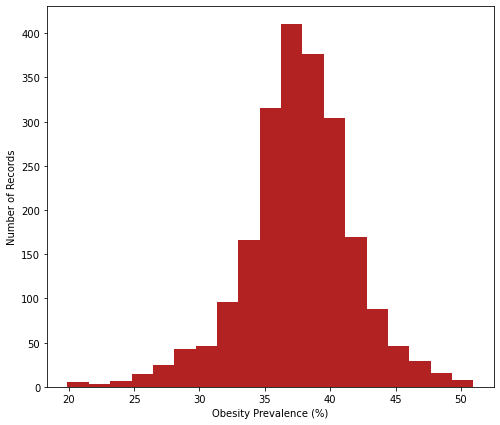

In [82]:
plt.figure(figsize = (8,7))
plt.hist(df_study['obesity_prevalence_2011'], bins=19, color='firebrick')
plt.xlabel('Obesity Prevalence (%)')
plt.ylabel('Number of Records')
plt.show()

In [83]:
print(stats.describe(df_study['obesity_prevalence_2011']))

DescribeResult(nobs=2166, minmax=(19.9, 50.95), mean=37.60413204062789, variance=17.27797483521311, skewness=-0.34778518404006337, kurtosis=1.2958924290942102)


Based on the skewness and kurtosis, the distribution of the target is near normal.

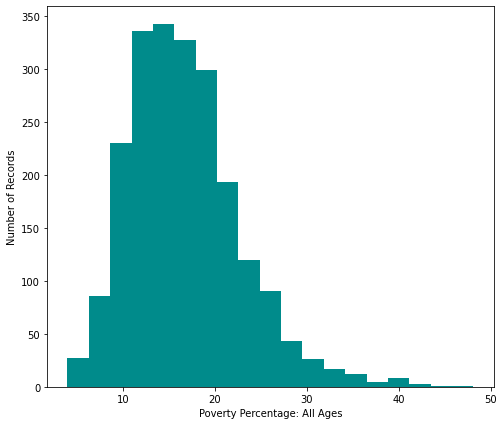

In [84]:
plt.figure(figsize = (8,7))
plt.hist(df_study['Poverty_Percent_All_Ages'], bins=19, color='darkcyan')
plt.xlabel("Poverty Percentage: All Ages")
plt.ylabel('Number of Records')
plt.show()

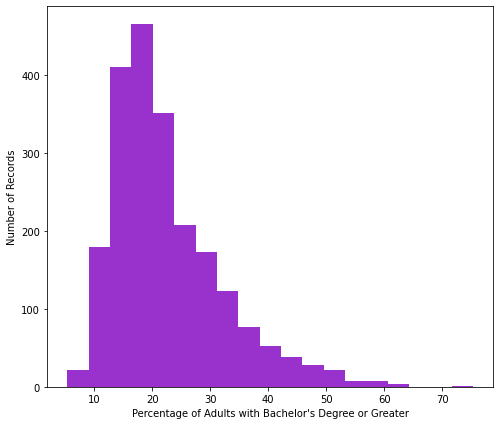

In [85]:
plt.figure(figsize = (8,7))
plt.hist(df_study['Percent_adult_w_bachelor_deg_or_GT_2015-19'], bins=19, color='darkorchid')
plt.xlabel("Percentage of Adults with Bachelor's Degree or Greater")
plt.ylabel('Number of Records')
plt.show()

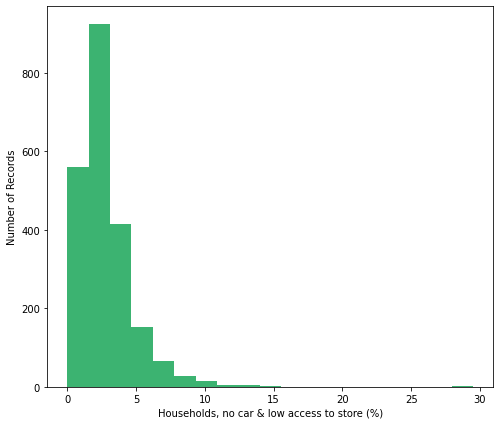

In [86]:
plt.figure(figsize = (8,7))
plt.hist(df_study['PCT_LACCESS_HHNV10'], bins=19, color='mediumseagreen')
plt.xlabel("Households, no car & low access to store (%)")
plt.ylabel('Number of Records')
plt.show()

In [87]:
corr = np.abs(df_study.loc[:, ~df_study.columns.isin(['State', 'County', 'FIPS'])].corr()['obesity_prevalence_2011']).sort_values(ascending=False)
corr_min = 0.5
high_corr = corr[(corr > corr_min)]
print('{} variables correlated to obesity_prevalence_2011 with a coefficient greater than {}:'.format(len(high_corr)-1, corr_min))
print('\n')
high_corr

10 variables correlated to obesity_prevalence_2011 with a coefficient greater than 0.5:




obesity_prevalence_2011                       1.000000
Percent_adult_w_bachelor_deg_or_GT_2015-19    0.730063
Percent_adult_w_LT_HS_diploma_2015-19         0.633320
Poverty_Percent_Under_Age_18                  0.625619
Poverty_Percent_Ages_5-17                     0.623371
Med_Household_Income                          0.614903
Poverty_Percent_All_Ages                      0.611323
PC_SNAPBEN12                                  0.594688
PCT_FREE_LUNCH10                              0.583834
Percent_adult_w_HS_diploma_only_2015-19       0.578547
PCT_LACCESS_HHNV10                            0.530064
Name: obesity_prevalence_2011, dtype: float64

All of the correlations between obesity_prevalence_2011 and the independent variables are less than 0.8

##Set the dependent and independent variables, and split the data

In [88]:
y = df_study['obesity_prevalence_2011']
X = df_study.loc[:, ~df_study.columns.isin(['State', 'County', 'FIPS', 'obesity_prevalence_2011'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465)

##Ridge Regression

In [89]:
params = {'alphas': [np.power(10.0,p) for p in np.arange(-10,40,1)], 
          'cv': 5}

# Initialize and fit the model
ridge_cv = RidgeCV(**params)
ridge_cv.fit(X_train, y_train)

ridge_cv_preds_dict = get_preds(ridge_cv, 'RidgeCV')

ridge_cv_metrics_dict = get_metrics(ridge_cv, 'RidgeCV', ridge_cv_preds_dict, 'baseline')

Best alpha value is: 10.0
R-squared of the model in training set is: 0.7518580838618137
-----Test set statistics-----
R-squared of the model in test set is: 0.741017095959312
Mean absolute error of the prediction is: 1.5605138288072167
Mean squared error of the prediction is: 4.089947916508514
Root mean squared error of the prediction is: 2.022361964760145
Mean absolute percentage error of the prediction is: 4.176687665628896


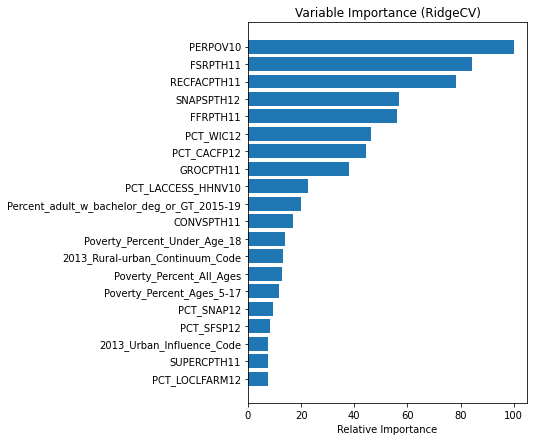

In [90]:
plt.figure(figsize = (5,7))
plot_feat_imp(ridge_cv, 'RidgeCV', 20, X)

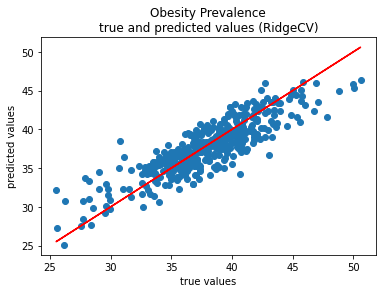

In [91]:
plt.figure(figsize = (6,4))
plot_preds('RidgeCV', ridge_cv_preds_dict)

##Lasso Regression

In [92]:
params = {'eps': 0.000001, 
          'cv': 5,
          'max_iter' : 4000}

# Initialize and fit the model
lasso_cv = LassoCV(**params)
lasso_cv.fit(X_train, y_train)

lasso_cv_preds_dict = get_preds(lasso_cv, 'LassoCV')

lasso_cv_metrics_dict = get_metrics(lasso_cv, 'LassoCV', lasso_cv_preds_dict, 'baseline')

Best alpha value is: 0.03411655169900059
R-squared of the model in training set is: 0.7440495159949003
-----Test set statistics-----
R-squared of the model in test set is: 0.7448615848517319
Mean absolute error of the prediction is: 1.5490974835388673
Mean squared error of the prediction is: 4.0292344134538
Root mean squared error of the prediction is: 2.007295298020149
Mean absolute percentage error of the prediction is: 4.150871313310027


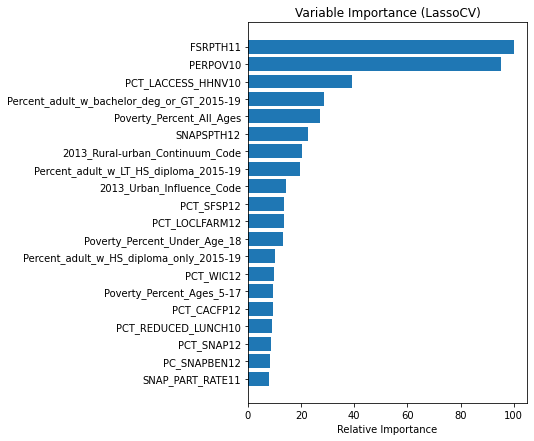

In [93]:
plt.figure(figsize = (5,7))
plot_feat_imp(lasso_cv, 'LassoCV', 20, X)

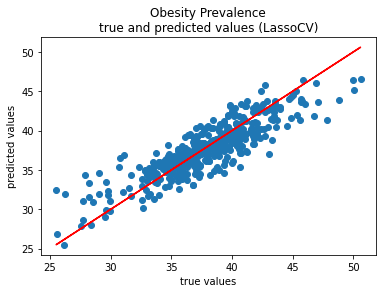

In [94]:
plt.figure(figsize = (6,4))
plot_preds('LassoCV', lasso_cv_preds_dict)

##Elastic Net Regression

In [95]:
params = {'eps': 0.000001, 
          'cv': 5,
          'max_iter' : 4000}

# Initialize and fit the model
elasticnet_cv = ElasticNetCV(**params)
elasticnet_cv.fit(X_train, y_train)

elasticnet_cv_preds_dict = get_preds(elasticnet_cv, 'ElasticNetCV')

elasticnet_cv_metrics_dict = get_metrics(elasticnet_cv, 'ElasticNetCV', elasticnet_cv_preds_dict, 'baseline')

Best alpha value is: 0.06823310339800115
R-squared of the model in training set is: 0.7421172190013774
-----Test set statistics-----
R-squared of the model in test set is: 0.7435607449695393
Mean absolute error of the prediction is: 1.552329798259603
Mean squared error of the prediction is: 4.0497777284096355
Root mean squared error of the prediction is: 2.0124059551714795
Mean absolute percentage error of the prediction is: 4.159525737943075


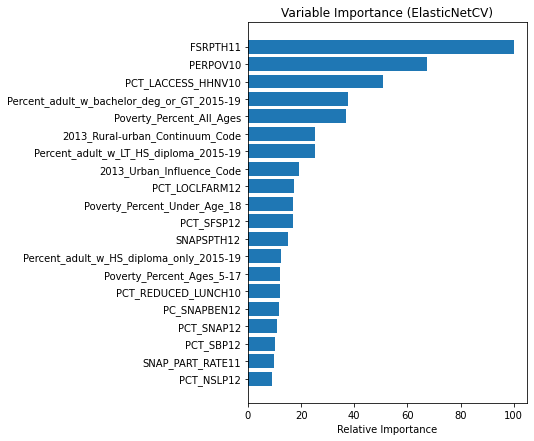

In [96]:
plt.figure(figsize = (5,7))
plot_feat_imp(elasticnet_cv, 'ElasticNetCV', 20, X)

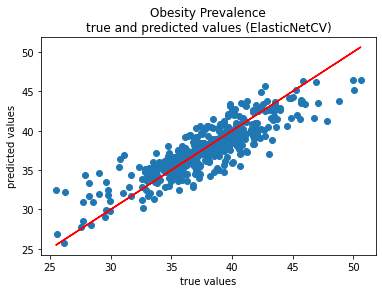

In [97]:
plt.figure(figsize = (6,4))
plot_preds('ElasticNetCV', elasticnet_cv_preds_dict)

##Support Vector Regression

Grid Search is used here for SVR.  In order to narrow in on the following ranges for C and epsilon, grid search was first run with wider ranges.  

In [98]:
c_list = list(np.arange(2245, 2275, 9))
print(c_list)
print(len(c_list))

[2245, 2254, 2263, 2272]
4


In [99]:
eps_list = list(np.arange(1.05, 1.15, 0.03))
print(eps_list)
print(len(eps_list))

[1.05, 1.08, 1.11, 1.1400000000000001]
4


In [100]:
params = {'C': c_list,
          'epsilon': eps_list}

# Initialize and fit the model
svr_clf = GridSearchCV(SVR(), params)
svr_clf.fit(X_train, y_train)

svr_clf_preds_dict = get_preds(svr_clf, 'SupportVectorRegressor_Grid_Search')

svr_clf_metrics_dict = get_metrics(svr_clf, 'SupportVectorRegressor_Grid_Search', svr_clf_preds_dict, 'baseline')

print('/n')
print("Best parameters are: {}".format(svr_clf.best_params_))

Best alpha value is: nan
R-squared of the model in training set is: 0.4727067416258428
-----Test set statistics-----
R-squared of the model in test set is: 0.4362396979153955
Mean absolute error of the prediction is: 2.2648224827099566
Mean squared error of the prediction is: 8.903098378103325
Root mean squared error of the prediction is: 2.9838060221977107
Mean absolute percentage error of the prediction is: 6.226363284020745
/n
Best parameters are: {'C': 2272, 'epsilon': 1.1400000000000001}


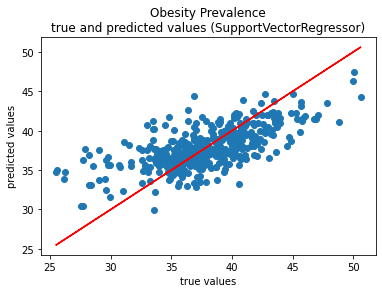

In [101]:
plt.figure(figsize = (6,4))
plot_preds('SupportVectorRegressor', svr_clf_preds_dict)

##Random Forest Regression

In [102]:
params = {'n_estimators': 500,
          'max_depth': 3}

# Initialize and fit the model
random_forest = ensemble.RandomForestRegressor(**params)
random_forest.fit(X_train, y_train)

random_forest_preds_dict = get_preds(random_forest, 'RandomForestRegressor')

random_forest_metrics_dict = get_metrics(random_forest, 'RandomForestRegressor', random_forest_preds_dict, 'baseline')

Best alpha value is: nan
R-squared of the model in training set is: 0.7136836444246653
-----Test set statistics-----
R-squared of the model in test set is: 0.6416293843079369
Mean absolute error of the prediction is: 1.8431250353007747
Mean squared error of the prediction is: 5.659513157506923
Root mean squared error of the prediction is: 2.378973130892176
Mean absolute percentage error of the prediction is: 4.979158642427404


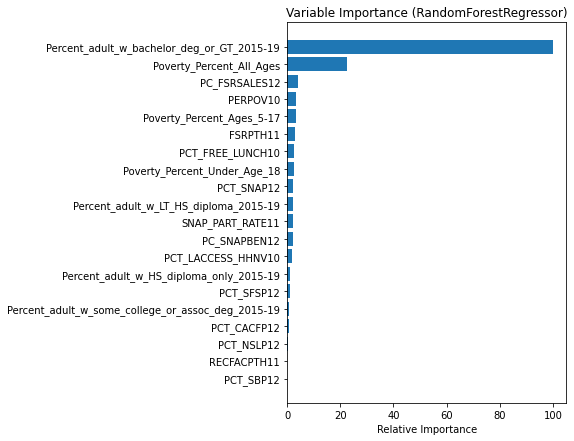

In [103]:
plt.figure(figsize = (5,7))
plot_feat_imp(random_forest, 'RandomForestRegressor', 20, X)

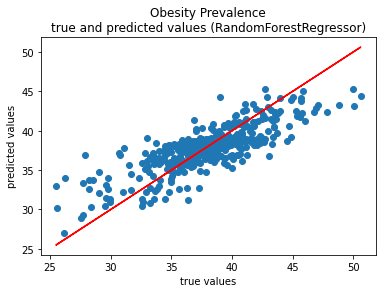

In [104]:
plt.figure(figsize = (6,4))
plot_preds('RandomForestRegressor', random_forest_preds_dict)

Next, try with Grid Search on the hyperparameters.

In [105]:
n_estimators_list = list(np.arange(300, 700, 100))
print(n_estimators_list)
print(len(n_estimators_list))

[300, 400, 500, 600]
4


In [106]:
max_depth_list = list(np.arange(2, 6, 1))
print(max_depth_list)
print(len(max_depth_list))

[2, 3, 4, 5]
4


In [107]:
params = {'n_estimators': n_estimators_list,
          'max_depth': max_depth_list}

# Initialize and fit the model
random_forest_clf = GridSearchCV(ensemble.RandomForestRegressor(), params)
random_forest_clf.fit(X_train, y_train)

random_forest_clf_preds_dict = get_preds(random_forest_clf, 'RandomForestRegressor_Grid_Search')

random_forest_clf_metrics_dict = get_metrics(random_forest_clf, 'RandomForestRegressor_Grid_Search', random_forest_clf_preds_dict, 'baseline')

print('/n')
print("Best parameters are: {}".format(random_forest_clf.best_params_))

Best alpha value is: nan
R-squared of the model in training set is: 0.8245345067434313
-----Test set statistics-----
R-squared of the model in test set is: 0.7102808462205734
Mean absolute error of the prediction is: 1.6651560500438833
Mean squared error of the prediction is: 4.575345441282927
Root mean squared error of the prediction is: 2.139005713242236
Mean absolute percentage error of the prediction is: 4.4869158734395285
/n
Best parameters are: {'max_depth': 5, 'n_estimators': 500}


Compared to the case with n_estimators = 500 and max_depth = 3, the grid search chooses n_estimators = 400 and max_depth = 5, which leads to a better performance on both the training and test sets, but there is still some overfitting as indicated by the difference between the train and test R-squared.

##Gradient Boosting Regression

In [108]:
params = {'n_estimators': 500,
          'max_depth': 3,
          'loss': 'squared_error'}

# Initialize and fit the model
gbr = ensemble.GradientBoostingRegressor(**params)
gbr.fit(X_train, y_train)

gbr_preds_dict = get_preds(gbr, 'GradientBoostingRegressor')

gbr_metrics_dict = get_metrics(gbr, 'GradientBoostingRegressor', gbr_preds_dict, 'baseline')

Best alpha value is: nan
R-squared of the model in training set is: 0.9694857744788635
-----Test set statistics-----
R-squared of the model in test set is: 0.7875821351994028
Mean absolute error of the prediction is: 1.4425506333718203
Mean squared error of the prediction is: 3.3545766535767116
Root mean squared error of the prediction is: 1.8315503415349281
Mean absolute percentage error of the prediction is: 3.8528060613119086


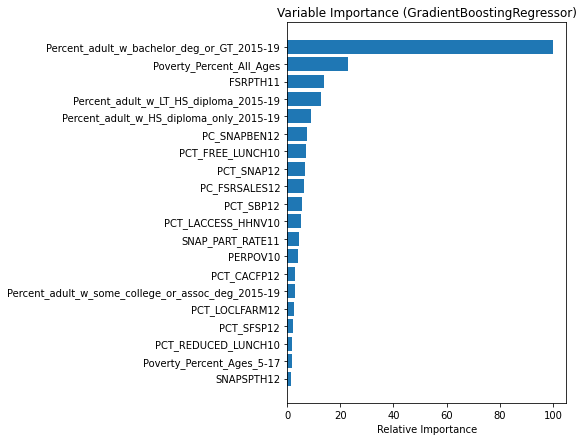

In [109]:
plt.figure(figsize = (5,7))
plot_feat_imp(gbr, 'GradientBoostingRegressor', 20, X)

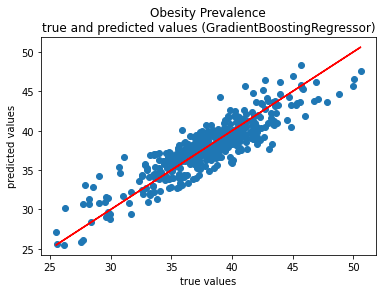

In [110]:
plt.figure(figsize = (6,4))
plot_preds('GradientBoostingRegressor', gbr_preds_dict)

Next, try with Grid Search on the hyperparameters.

In [111]:
n_estimators_list = list(np.arange(200, 600, 100))
print(n_estimators_list)
print(len(n_estimators_list))

[200, 300, 400, 500]
4


In [112]:
max_depth_list = list(np.arange(2, 6, 1))
print(max_depth_list)
print(len(max_depth_list))

[2, 3, 4, 5]
4


In [113]:
params = {'n_estimators': n_estimators_list,
          'max_depth': max_depth_list,
          'loss': ['squared_error']}

# Initialize and fit the model
gbr_clf = GridSearchCV(ensemble.GradientBoostingRegressor(), params)
gbr_clf.fit(X_train, y_train)

gbr_clf_preds_dict = get_preds(gbr_clf, 'GradientBoostingRegressor_Grid_Search')

gbr_clf_metrics_dict = get_metrics(gbr_clf, 'GradientBoostingRegressor_Grid_Search', gbr_clf_preds_dict, 'baseline')

print('/n')
print("Best parameters are: {}".format(gbr_clf.best_params_))

Best alpha value is: nan
R-squared of the model in training set is: 0.9618330098369157
-----Test set statistics-----
R-squared of the model in test set is: 0.7881069449070385
Mean absolute error of the prediction is: 1.459436693532538
Mean squared error of the prediction is: 3.346288676506338
Root mean squared error of the prediction is: 1.8292863844970633
Mean absolute percentage error of the prediction is: 3.9024300651113397
/n
Best parameters are: {'loss': 'squared_error', 'max_depth': 4, 'n_estimators': 200}


Compared to the case with n_estimators = 500 and max_depth = 3, the grid search chose n_estimators = 300 and max_depth = 4, which leads to a slight increase in performance on both the training and test set, but there is still some overfitting as indicated by the difference between the train and test R-squared.

##Comparison of Models

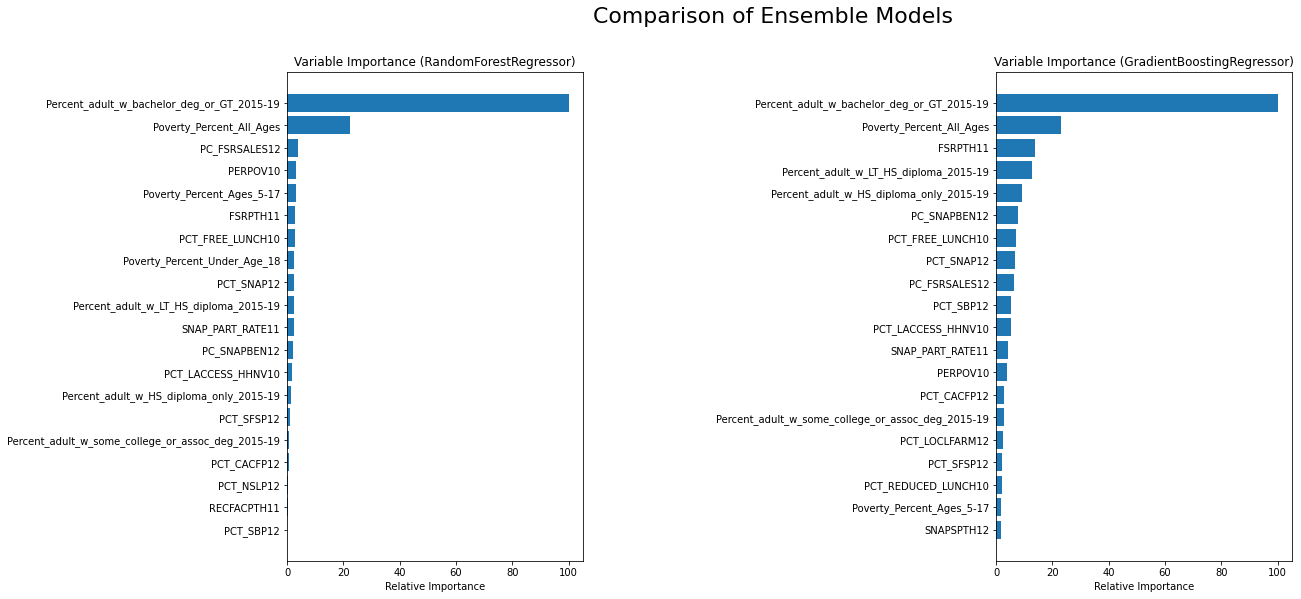

In [114]:
plt.figure(figsize = (18,9))

plt.suptitle('Comparison of Ensemble Models', fontsize=22)

plt.subplot(1, 3, 1)
plot_feat_imp(random_forest, 'RandomForestRegressor', 20, X)

plt.subplot(1, 3, 3)
plot_feat_imp(gbr, 'GradientBoostingRegressor', 20, X)

plt.show()

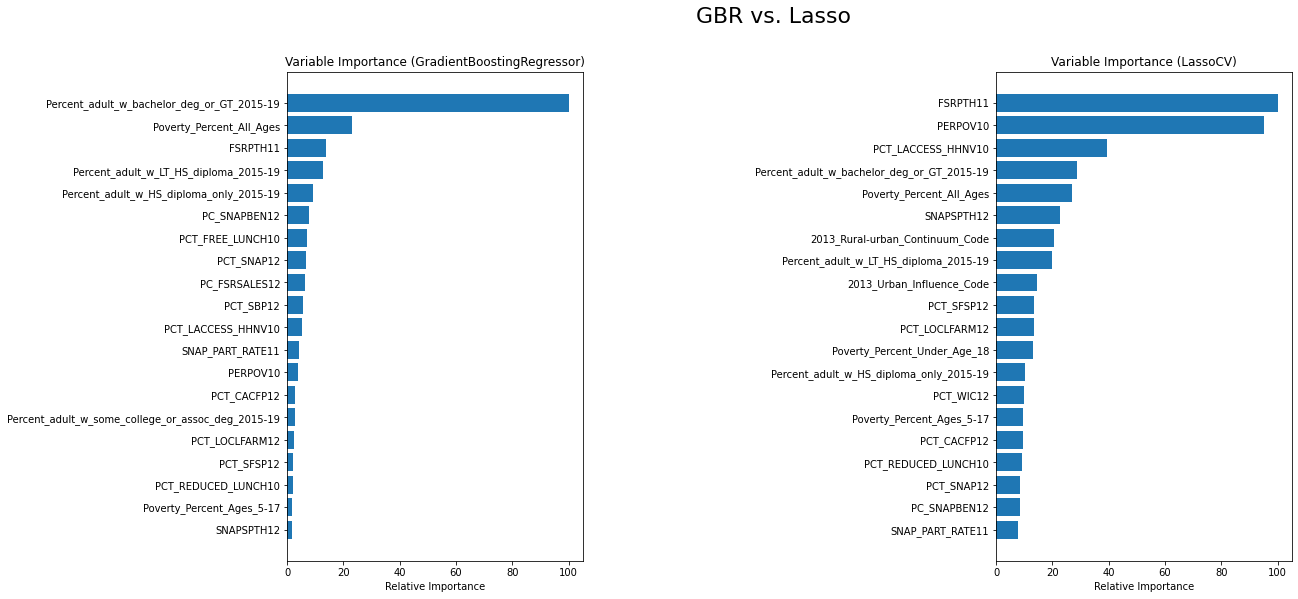

In [115]:
plt.figure(figsize = (18,9))

plt.suptitle('GBR vs. Lasso', fontsize=22)

plt.subplot(1, 3, 1)
plot_feat_imp(gbr, 'GradientBoostingRegressor', 20, X)

plt.subplot(1, 3, 3)
plot_feat_imp(lasso_cv, 'LassoCV', 20, X)

plt.show()

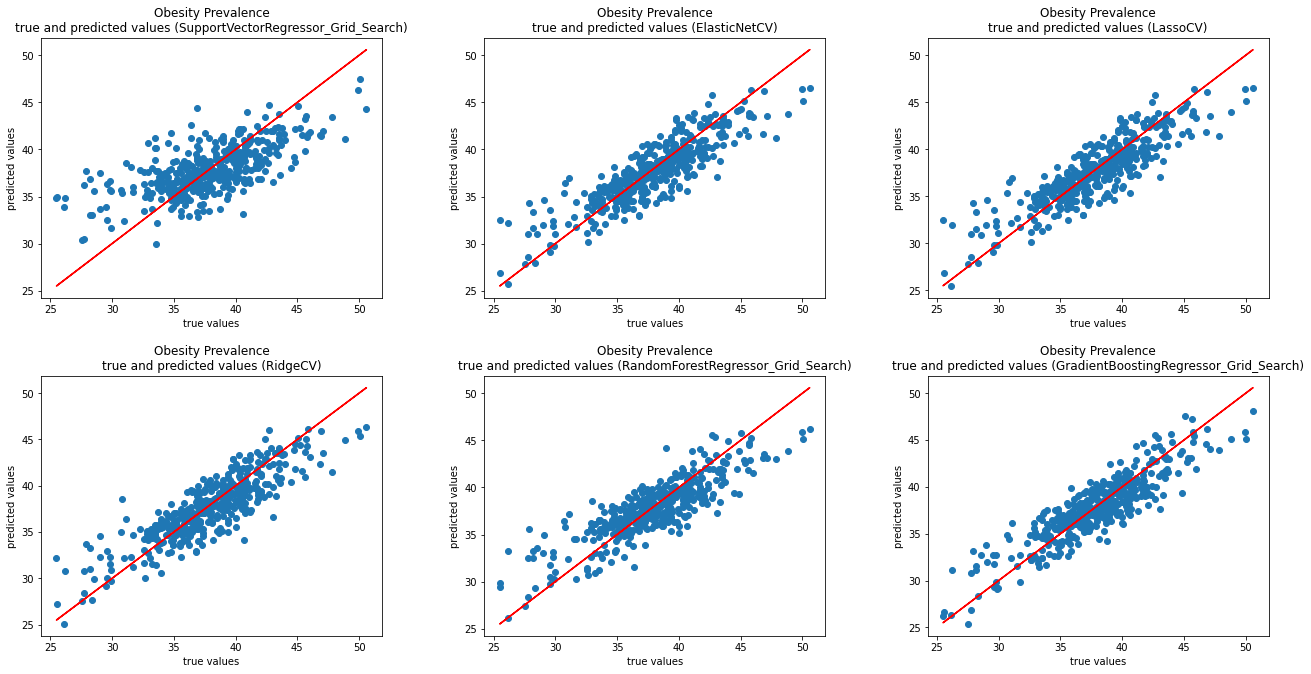

In [116]:
plt.figure(figsize = (22,11))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

plt.subplot(2, 3, 1)
plot_preds('SupportVectorRegressor_Grid_Search', svr_clf_preds_dict)

plt.subplot(2, 3, 2)
plot_preds('ElasticNetCV', elasticnet_cv_preds_dict)

plt.subplot(2, 3, 3)
plot_preds('LassoCV', lasso_cv_preds_dict)

plt.subplot(2, 3, 4)
plot_preds('RidgeCV', ridge_cv_preds_dict)

plt.subplot(2, 3, 5)
plot_preds('RandomForestRegressor_Grid_Search', random_forest_clf_preds_dict)

plt.subplot(2, 3, 6)
plot_preds('GradientBoostingRegressor_Grid_Search', gbr_clf_preds_dict)

plt.show()

In [117]:
dict_list = [gbr_metrics_dict, gbr_clf_metrics_dict, ridge_cv_metrics_dict, lasso_cv_metrics_dict, elasticnet_cv_metrics_dict, 
             random_forest_metrics_dict, random_forest_clf_metrics_dict, svr_clf_metrics_dict]

compare_metrics(dict_list).style.set_precision(precision=3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  after removing the cwd from sys.path.


,Method,Best_alpha,R_sq_train,R_sq_test,MAE,MSE,RMSE,MAPE,Comments
0,GradientBoostingRegressor,nan,0.969,0.788,1.443,3.355,1.832,3.853,baseline
1,GradientBoostingRegressor_Grid_Search,nan,0.962,0.788,1.459,3.346,1.829,3.902,baseline
6,RandomForestRegressor_Grid_Search,nan,0.825,0.710,1.665,4.575,2.139,4.487,baseline
2,RidgeCV,10.000,0.752,0.741,1.561,4.090,2.022,4.177,baseline
3,LassoCV,0.034,0.744,0.745,1.549,4.029,2.007,4.151,baseline
4,ElasticNetCV,0.068,0.742,0.744,1.552,4.050,2.012,4.160,baseline
5,RandomForestRegressor,nan,0.714,0.642,1.843,5.660,2.379,4.979,baseline
7,SupportVectorRegressor_Grid_Search,nan,0.473,0.436,2.265,8.903,2.984,6.226,baseline


The Gradient Boosting Regressor clearly has the best explanatory power (R-squared_train = 0.98), but the large difference between R-squared_train and R-squared_test shows the model is not generalizable, i.e. the model is overfitting.  In this case, having a generalizable model is more important.  Even though the Ridge, Lasso, and ElasticNet models have lower R-squared values, the values are nearly the same (at around 0.74 or 0.75) between train and test; thus, these models are very generalizable.  Furthermore, 0.74-0.75 can still be considered a satisfactory explanatory and predictive power.  Among the Ridge, Lasso, and ElasticNet, the Lasso is slightly more generalizable.  Lasso is therefore chosen as the best model to move forward.  Next, see if the Lasso performance can be improved with further feature engineering.

##Further Feature Engineering and Conclusions

Visualizize the feature importance of the Lasso model once again.

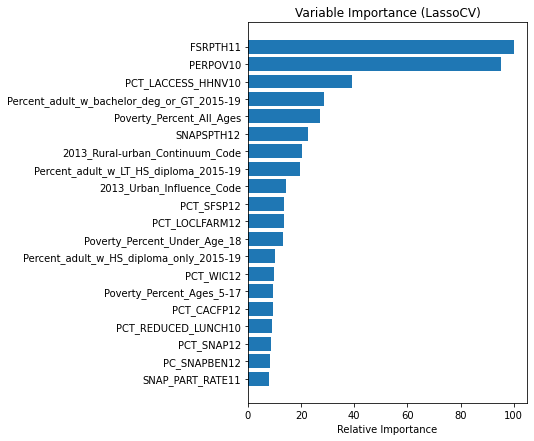

In [118]:
plt.figure(figsize = (5,7))
plot_feat_imp(lasso_cv, 'LassoCV', 20, X)

All three education levels show relatively high feature importance in the Lasso model.  Try simplifying the model by changing the Percent_adult_w_bachelor_deg_or_GT_2015-19 to a binary field, excluding the other education fields.

In [119]:
def categorize_edu(edu):
  if edu >= 50:
    return 1  #50% or more of the county's adult population has bachelor's degree or greater.
  else:
    return 0  #Less than 50% of the county's adult population has bachelor's degree or greater.

In [120]:
X_01 = X.copy()
X_01['adult_w_bachelor_deg_or_GT_2015-19'] = X_01['Percent_adult_w_bachelor_deg_or_GT_2015-19'].apply(categorize_edu)
print(X_01.groupby('adult_w_bachelor_deg_or_GT_2015-19')['Percent_adult_w_bachelor_deg_or_GT_2015-19'].count())

adult_w_bachelor_deg_or_GT_2015-19
0    2129
1      37
Name: Percent_adult_w_bachelor_deg_or_GT_2015-19, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


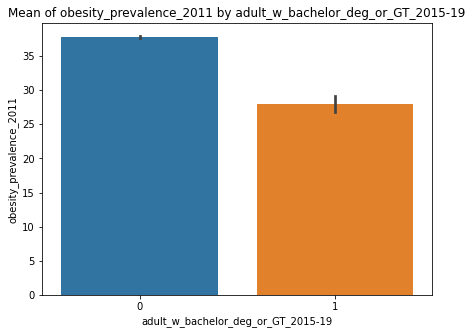

In [121]:
df = X_01.merge(y.to_frame(), how='right', left_index=True, right_index=True)

plt.figure(figsize=(7,5))

sns.barplot(df['adult_w_bachelor_deg_or_GT_2015-19'], df['obesity_prevalence_2011'])
plt.title('Mean of obesity_prevalence_2011 by adult_w_bachelor_deg_or_GT_2015-19')

plt.show()

In [122]:
drop = []
for col in X_01.columns:
  if col[:13] in ['Percent_adult']:
    drop.append(col)

X_01 = X_01.drop(columns = drop)

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X_01, y, test_size = 0.2, random_state = 465)

In [124]:
params = {'eps': 0.000001, 
          'cv': 5,
          'max_iter' : 4000}

# Initialize and fit the model
lasso_cv = LassoCV(**params)
lasso_cv.fit(X_train, y_train)

lasso_cv_preds_dict_01 = get_preds(lasso_cv, 'LassoCV_01')

lasso_cv_metrics_dict_01 = get_metrics(lasso_cv, 'LassoCV_01', lasso_cv_preds_dict_01, 'edu as binary')

Best alpha value is: 0.03411655169900059
R-squared of the model in training set is: 0.6653287944909361
-----Test set statistics-----
R-squared of the model in test set is: 0.6455873835995692
Mean absolute error of the prediction is: 1.8127087165980544
Mean squared error of the prediction is: 5.597007058827102
Root mean squared error of the prediction is: 2.365799454481952
Mean absolute percentage error of the prediction is: 4.899308941606061


In [125]:
df_study_01 = pd.concat([y, X_01], axis=1)

corr = np.abs(df_study_01[list(X_01.columns) + ['obesity_prevalence_2011']].corr()['Poverty_Percent_All_Ages']).sort_values(ascending=False)
corr_min = 0.5
high_corr = corr[(corr > corr_min)]
print('{} variables correlated to Poverty_Percent_All_Ages with a coefficient greater than {}:'.format(len(high_corr)-1, corr_min))
print('\n')
high_corr

9 variables correlated to Poverty_Percent_All_Ages with a coefficient greater than 0.5:




Poverty_Percent_All_Ages        1.000000
Poverty_Percent_Under_Age_18    0.932129
Poverty_Percent_Ages_5-17       0.927960
PC_SNAPBEN12                    0.787507
PCT_FREE_LUNCH10                0.782456
Med_Household_Income            0.775341
obesity_prevalence_2011         0.611323
PERPOV10                        0.603614
SNAPSPTH12                      0.552450
PCT_LACCESS_HHNV10              0.523698
Name: Poverty_Percent_All_Ages, dtype: float64

Poverty_Percent_All_Ages has a high feature importance, but it is strongly correlated with Poverty_Percent_Under_Age_18 and Poverty_Percent_Ages_5-17.  Starting from the baseline, see if the model performance changes after dropping Poverty_Percent_Under_Age_18 and Poverty_Percent_Ages_5-17.


In [126]:
X_02 = X.copy()
X_02 = X_02.drop(columns = ['Poverty_Percent_Under_Age_18', 'Poverty_Percent_Ages_5-17'])

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X_02, y, test_size = 0.2, random_state = 465)

In [128]:
params = {'eps': 0.000001, 
          'cv': 5,
          'max_iter' : 4000}

# Initialize and fit the model
lasso_cv = LassoCV(**params)
lasso_cv.fit(X_train, y_train)

lasso_cv_preds_dict_02 = get_preds(lasso_cv, 'LassoCV_02')

lasso_cv_metrics_dict_02 = get_metrics(lasso_cv, 'LassoCV_02', lasso_cv_preds_dict_02, 'drop specific poverty levels')

Best alpha value is: 0.03411655169900059
R-squared of the model in training set is: 0.7432207161900948
-----Test set statistics-----
R-squared of the model in test set is: 0.7445912248109746
Mean absolute error of the prediction is: 1.5506139087273905
Mean squared error of the prediction is: 4.033504033062469
Root mean squared error of the prediction is: 2.0083585419596943
Mean absolute percentage error of the prediction is: 4.156213550116227


In [129]:
dict_list = [lasso_cv_metrics_dict, lasso_cv_metrics_dict_01, lasso_cv_metrics_dict_02]

compare_metrics(dict_list)

,Method,Best_alpha,R_sq_train,R_sq_test,MAE,MSE,RMSE,MAPE,Comments
0,LassoCV,0.034117,0.744050,0.744862,1.549097,4.029234,2.007295,4.150871,baseline
2,LassoCV_02,0.034117,0.743221,0.744591,1.550614,4.033504,2.008359,4.156214,drop specific poverty levels
1,LassoCV_01,0.034117,0.665329,0.645587,1.812709,5.597007,2.365799,4.899309,edu as binary


The two iterations of feature engineering resulted in degraded performance of the Lasso model, especially the iteration where the educaton information was condensed into a binary variable.  This implies that the education levels are important for both explanatory and predictive power.  
<br>
Aside from the fields on education and percentage in poverty, variables from the Food Environment Atlas with high feature importance for predicting obesity prevalence include: 
<br>
* FSRPTH11:  Full-service restaurants/1,000 pop, 2011
* PERPOV10:  Persistent-poverty counties, 2010
* PCT_LACCESS_HHNV10:  Households, no car & low access to store (%), 2010
* SNAPSPTH12:  SNAP-authorized stores/1,000 pop, 2012
* PCT_LOCLFARM12:  Farms with direct sales (%), 2012
* PCT_SFSP12:  Summer Food Service Program participants (% children), 2012
* PCT_REDUCED_LUNCH10:  Students eligible for reduced-price lunch (%), 2010
* PCT_WIC12:  WIC participants (% pop), 2012
* PCT_SNAP12:  SNAP participants (% pop), 2012
* SNAP_PART_RATE11:  SNAP participants (% eligible pop), 2011
* PCT_SBP12:  School Breakfast Program participants (% children), 2012
* PC_SNAPBEN12:  SNAP benefits per capita, 2012
* PCT_NSLP12:  National School Lunch Program participants (% children), 2012
* PCT_CACFP12:  Child & Adult Care (% pop), 2012

Finally, refer to the actual coefficient values as well as the scatter plots to examine the directional relationships between some of these independent variables and the target, obesity_prevalence_2011, in order to understand the effect that increasing or decreasing a variable has on the target.


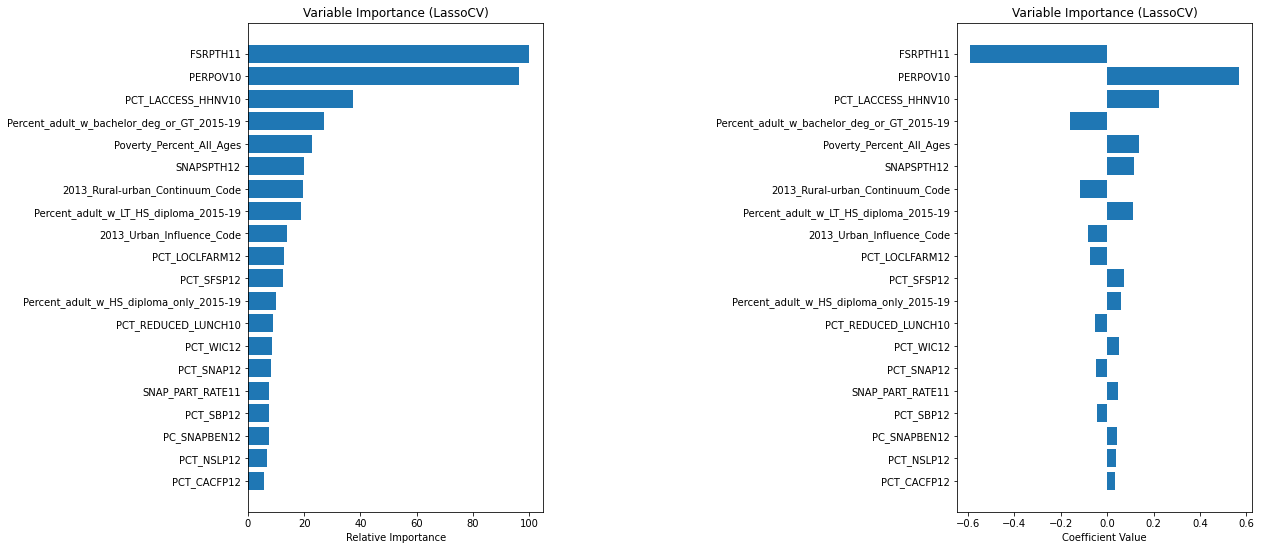

In [130]:
plt.figure(figsize = (18,9))

plt.subplot(1, 3, 1)
plot_feat_imp(lasso_cv, 'LassoCV', 20, X)

plt.subplot(1, 3, 3)
plot_coef(lasso_cv, 'LassoCV', 20, X)

plt.show()

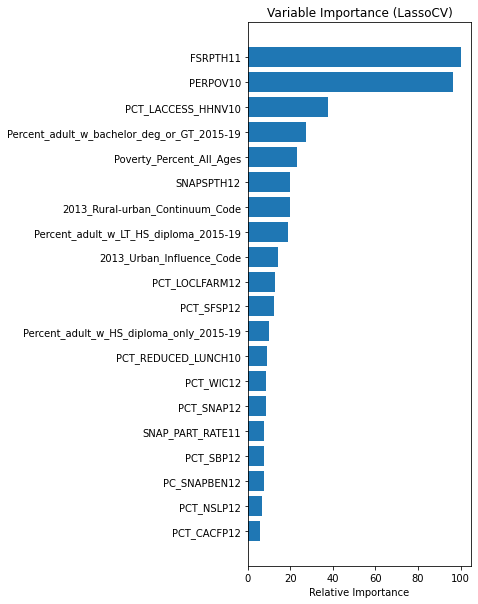

In [131]:
plt.figure(figsize = (4,10))

plot_feat_imp(lasso_cv, 'LassoCV', 20, X)

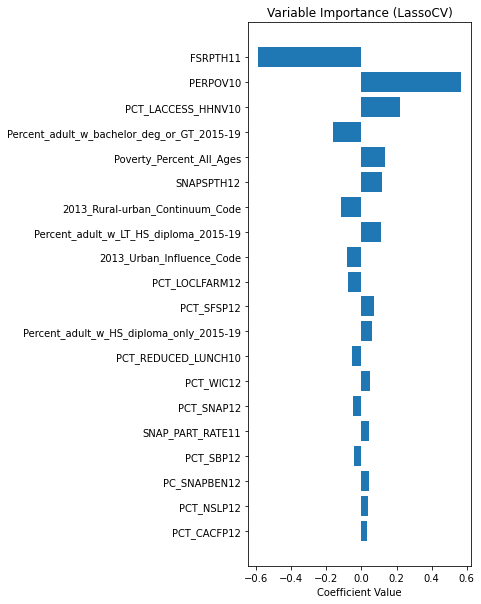

In [132]:
plt.figure(figsize = (4,10))

plot_coef(lasso_cv, 'LassoCV', 20, X)

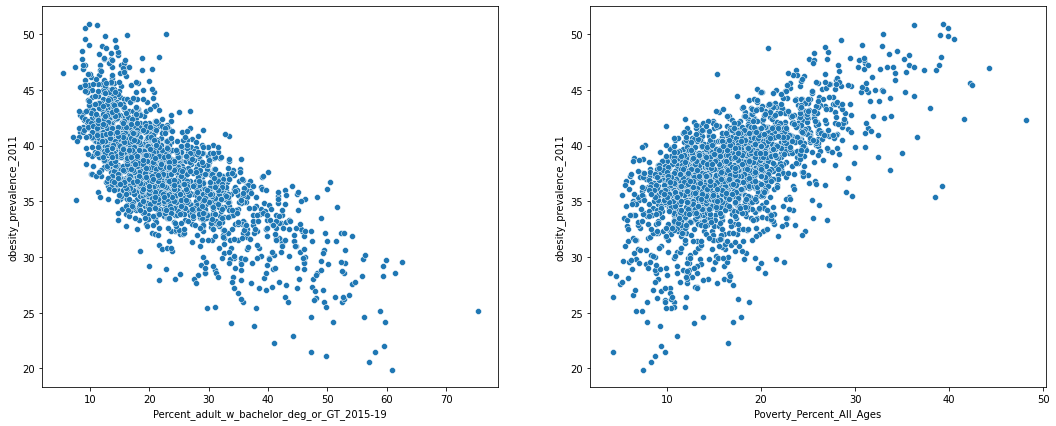

In [133]:
plt.figure(figsize = (18,7))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df_study, x="Percent_adult_w_bachelor_deg_or_GT_2015-19", y="obesity_prevalence_2011")

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_study, x="Poverty_Percent_All_Ages", y="obesity_prevalence_2011")

plt.show()

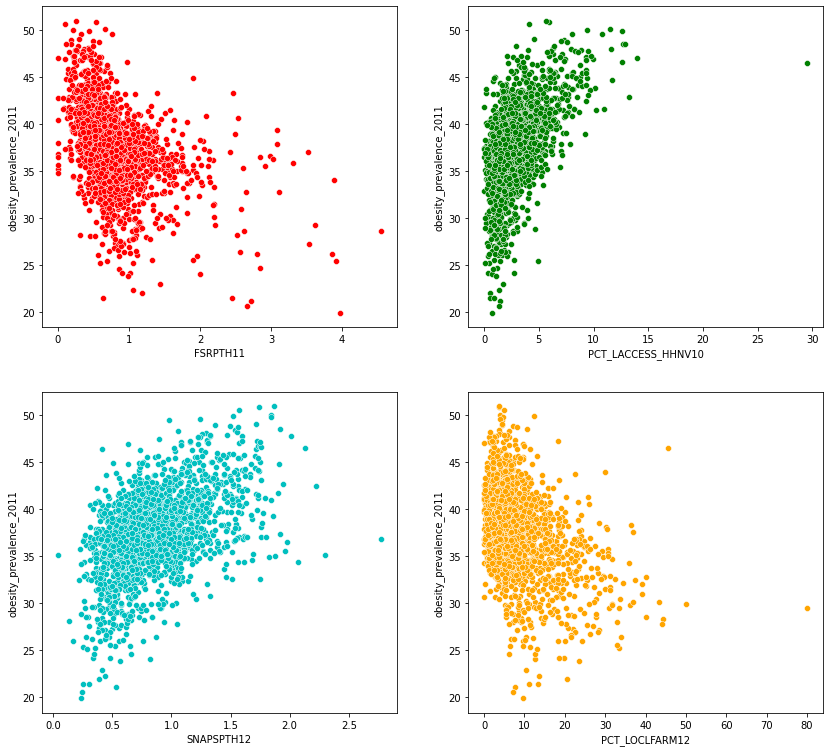

In [134]:
plt.figure(figsize = (14,13))

plt.subplot(2, 2, 1)
sns.scatterplot(data=df_study, x="FSRPTH11", y="obesity_prevalence_2011", color='r')

plt.subplot(2, 2, 2)
sns.scatterplot(data=df_study, x="PCT_LACCESS_HHNV10", y="obesity_prevalence_2011", color='g')

plt.subplot(2, 2, 3)
sns.scatterplot(data=df_study, x="SNAPSPTH12", y="obesity_prevalence_2011", color='c')

plt.subplot(2, 2, 4)
sns.scatterplot(data=df_study, x="PCT_LOCLFARM12", y="obesity_prevalence_2011", color='orange')

plt.show()

In [135]:
# PCT_LACCESS_HHNV10:  Households, no car & low access to store (%), 2010
def categorize_hh(hh):
  if hh >= 5:
    return 1
  else:
    return 0

df_study_post = df_study.copy()
df_study_post['PCT_LACCESS_HHNV10_GT_5'] = df_study_post['PCT_LACCESS_HHNV10'].apply(categorize_hh)

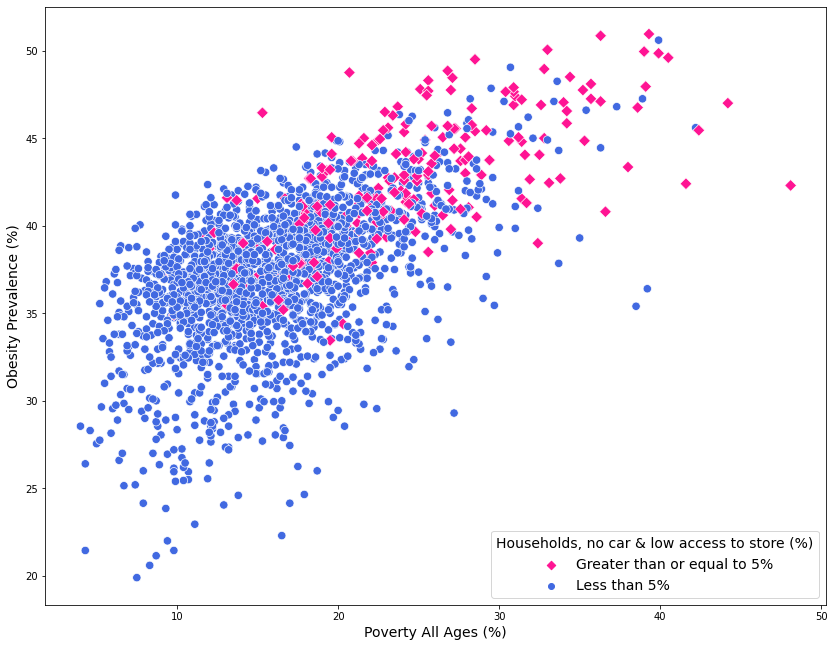

In [136]:
font_s = 14

plt.figure(figsize = (14,11))

ax = sns.scatterplot(data=df_study_post, x="Poverty_Percent_All_Ages", y="obesity_prevalence_2011", hue="PCT_LACCESS_HHNV10_GT_5", hue_order=[1, 0],
                     style="PCT_LACCESS_HHNV10_GT_5", s=70, palette={1:'deeppink', 0:'royalblue'}, markers={1:'D', 0:'o'})
ax.set_xlabel("Poverty All Ages (%)", fontsize = font_s)
ax.set_ylabel("Obesity Prevalence (%)", fontsize = font_s)

legend_labels, _= ax.get_legend_handles_labels()
lg = ax.legend(legend_labels, ['Greater than or equal to 5%', 'Less than 5%'], loc='lower right', title='Households, no car & low access to store (%)', fontsize=font_s)
lg_title = lg.get_title()
lg_title.set_fontsize(font_s)

plt.show()

In [137]:
cc = ['Percent_adult_w_LT_HS_diploma_2015-19', 'Percent_adult_w_HS_diploma_only_2015-19',
      'Percent_adult_w_some_college_or_assoc_deg_2015-19', 'Percent_adult_w_bachelor_deg_or_GT_2015-19']

conds = [(df_study_post[cc[0]] >= df_study_post[cc[1]]) & (df_study_post[cc[0]] >= df_study_post[cc[2]]) & (df_study_post[cc[0]] >= df_study_post[cc[3]]),
         (df_study_post[cc[1]] > df_study_post[cc[0]]) & (df_study_post[cc[1]] >= df_study_post[cc[2]]) & (df_study_post[cc[1]] >= df_study_post[cc[3]]),
         (df_study_post[cc[2]] > df_study_post[cc[0]]) & (df_study_post[cc[2]] > df_study_post[cc[1]]) & (df_study_post[cc[2]] >= df_study_post[cc[3]]),
         (df_study_post[cc[3]] > df_study_post[cc[0]]) & (df_study_post[cc[3]] > df_study_post[cc[1]]) & (df_study_post[cc[3]] > df_study_post[cc[2]])]

cond_resp = [0, 1, 2, 3]

df_study_post['edu_majority'] = np.select(conds, cond_resp)

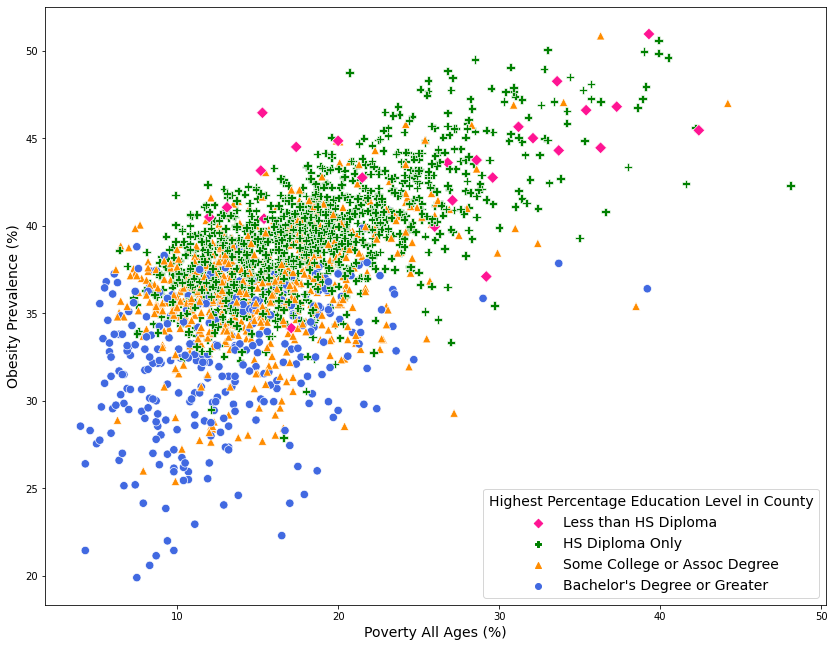

In [138]:
font_s = 14

plt.figure(figsize = (14,11))

ax = sns.scatterplot(data=df_study_post, x="Poverty_Percent_All_Ages", y="obesity_prevalence_2011", hue="edu_majority", hue_order=[0, 1, 2, 3],
                     style="edu_majority", s=70, palette={0:'deeppink', 1:'g', 2:'darkorange', 3:'royalblue'}, markers={0:'D', 1:'P', 2:'^', 3:'o'})
ax.set_xlabel("Poverty All Ages (%)", fontsize = font_s)
ax.set_ylabel("Obesity Prevalence (%)", fontsize = font_s)

legend_labels, _= ax.get_legend_handles_labels()
lg = ax.legend(legend_labels, ["Less than HS Diploma", "HS Diploma Only", "Some College or Assoc Degree", "Bachelor's Degree or Greater"], loc='lower right', title='Highest Percentage Education Level in County', fontsize=font_s)
lg_title = lg.get_title()
lg_title.set_fontsize(font_s)

plt.show()